# thư viện

In [ ]:
import pandas as pd
from sklearn import preprocessing
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches
import scipy.stats as stats
from scipy.stats import chi2_contingency

# Giai đoạn xử lý và vẽ biểu đồ
Hào: Theo tôi nghĩ, ý kiến của thầy là khá chính xác và hợp lý, vì thế chúng ta sẽ EDA trực quan bằng cách sử dụng bộ dữ liệu trước khi tách cột.<br>
Còn việc tách cột sẽ phù hợp để phục vụ cho việc tạo mô hình.

In [ ]:
df_buoc3 = pd.read_excel('/content/dienthoai_buoc4.xlsx')


In [ ]:
df_buoc3.sample()

,Tên,Giá,Kích thước màn hình,Công nghệ màn hình,Camera sau,Camera trước,CPU,Dung lượng RAM,Bộ nhớ trong,Thẻ SIM,Hệ điều hành,Độ phân giải màn hình,Loại CPU,Quay video,Tính năng camera,GPU,Khe cắm thẻ nhớ,Công nghệ sạc,Cổng sạc,Wi-Fi,Bluetooth,GPS,Trọng lượng,Chất liệu mặt lưng,Chất liệu khung viền,"Chỉ số kháng nước, bụi",Cảm biến,Tính năng đặc biệt,Jack tai nghe 3.5,Nguồn,Dài,Dày,Rộng,Loại pin,Dung lượng pin
53,OPPO Reno6 Z 5G,10490000,NaN,AMOLED,64MP (Chính) + 8MP (Góc rộng) + 2MP (Marco),32MP,MediaTek Dimensity 800U 5G 8 nhân,NaN,NaN,2 SIM (Nano-SIM),"ColorOS 11.3, nền tảng Android 11",1080 x 2400,2 nhân 2.4 GHz 6 nhân 2 GHz,"4K 2160p@30fps, FullHD 1080p@60fps",NaN,Mali-G57 MC3,NaN,Sạc siêu nhanh 30W,USB Type-C,"Wifi 6, 2.4G/5G, 802.11 a/b/g/n/ac/ax",5.1,NaN,NaN,Kim loại,Kính,NaN,Cảm biến vân tay trong màn hình,"Hỗ trợ 5G, Nhận diện khuôn mặt, Bảo mật vân tay",Có,Cellphones,NaN,NaN,NaN,NaN,4310.0


In [ ]:
df_buoc3.columns

Index(['Tên', 'Giá', 'Kích thước màn hình', 'Công nghệ màn hình', 'Camera sau',
       'Camera trước', 'CPU', 'Dung lượng RAM', 'Bộ nhớ trong', 'Thẻ SIM',
       'Hệ điều hành', 'Độ phân giải màn hình', 'Loại CPU', 'Quay video',
       'Tính năng camera', 'GPU', 'Khe cắm thẻ nhớ', 'Công nghệ sạc',
       'Cổng sạc', 'Wi-Fi', 'Bluetooth', 'GPS', 'Trọng lượng',
       'Chất liệu mặt lưng', 'Chất liệu khung viền', 'Chỉ số kháng nước, bụi',
       'Cảm biến', 'Tính năng đặc biệt', 'Jack tai nghe 3.5', 'Nguồn', 'Dài',
       'Dày', 'Rộng', 'Loại pin', 'Dung lượng pin'],
      dtype='object')

# Xử lý dữ liệu

In [ ]:
def KiemTraThuocTinh(data, col):
  print("\n- Thuộc tính", col, "có tổng cộng", len(df_buoc3.loc[:, [col]]), "dòng.\n")
  print("- Số điểm dữ liệu null:",df_buoc3.loc[:, [col]].isnull().sum()[0], '\n')
  print("- Số lượng dữ liệu độc nhất: ", len(df_buoc3[col].unique()))
  print("- Các dữ liệu độc nhất (unique):")
  print(df_buoc3[col].unique())

In [ ]:
def encode(df):
    df = df.copy()
    encoders = dict()
    for col_name in df.columns:
        series = df[col_name]
        label_encoder = preprocessing.LabelEncoder()
        df[col_name] = pd.Series(
            label_encoder.fit_transform(series),
            index=series.index
        )
        encoders[col_name] = label_encoder
        dict_to_check = dict(zip(encoders[col_name].classes_, encoders[col_name].transform(encoders[col_name].classes_)))
        # chỉnh lại giá trị null sẽ là -1, thay vì là một con số bất kì mà LabelEncoder đặt cho
        try:
          df[col_name] = df[col_name].replace(dict_to_check[np.nan], -1)
          dict_to_check[np.nan] = -1
        except:
          continue
    return df, encoders,dict_to_check

def decode(df, encoders):
    df = df.copy()
    for col_name in df.columns:
        series = df[col_name].apply(round)
        df[col_name] = pd.Series(encoders[col_name].inverse_transform(series))
    return df

def decode_using_replace(df,diction): #for 1 column only
  new_dict = dict([(value, key) for key, value in diction.items()])
  df=df.replace({df.columns[0]:new_dict})
  return df


In [ ]:
def encode_column(Series):
  le = preprocessing.LabelEncoder()
  df_encode=pd.DataFrame(le.fit_transform(Series),columns=[Series.name])
  le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
  return df_encode,le_name_mapping

In [ ]:
def Ve_Pie(data, col):
  dataCount = data[col].value_counts(dropna=False)
  labels = [f'{l}, {s*100/(dataCount.sum()):0.1f}%' for l, s in zip(dataCount.index, dataCount)]
  # Chọn chỉ những giá trị lớn để hiển thị trên pie
  labels_pie = [l if s/(dataCount.sum()) >0.05 else '' for l, s in zip(dataCount.index, dataCount)]
  plt.figure(figsize=(6,5))
  colors = sns.color_palette('pastel') 
  pie = plt.pie(dataCount,shadow=True, 
                startangle=90,wedgeprops = { 'linewidth': 0.5, "edgecolor" :"k" }, labels = labels_pie)
  handles = []

  for i, l in enumerate(labels):
      handles.append(matplotlib.patches.Patch(color=plt.cm.Set3((i)/8.), label=l))
  plt.legend(labels, bbox_to_anchor=(1.25, 1.5), loc="upper left", 
                            bbox_transform=plt.gcf().transFigure)

  plt.title("Tần suất các giá trị của thuộc tính '"+col+"'",loc="center",fontsize=20)
  plt.subplots_adjust(left=0, bottom=0, right=0.58)
  # plt.savefig('phobert_location.png', bbox_inches='tight', dpi=300)

In [ ]:
def Ve_Hist(data, col):
  df_encode, encoder, dict_data =encode(data[[col]])
  sns.set_theme(style="whitegrid")
  sns.displot(df_encode[col], discrete=True, shrink=.8,kde=True).set(title='Histogram thể hiện tần suất của các giá trị ở thuộc tính ' + str(col))
  plt.show()
  print("Ý nghĩa của các giá trị:", dict_data)

In [ ]:
def Ve_RelPlot(data, col):
  df_encode, encoder, dict_data =encode(data[[col]])
  sns.regplot(x=df_encode.iloc[:,0],y=data["Giá"]).set(title='Biểu đồ tương quan giữa ' + str(col) + " và GIÁ")
  plt.show()

In [ ]:
def Ve_BoxPlot_BienPhanLoai_vs_Gia(data, col):
  plt.clf()
  if len(data[col].unique()) >12:
    df_encode, encoder, dict_data =encode(data[[col]])
    fig, ax = plt.subplots(figsize=(10, 10))
    sns.boxplot(x = df_encode.iloc[:,0],y = data["Giá"])
    print("Ý nghĩa của các giá trị:", dict_data)
  else:
    fig, ax = plt.subplots(figsize=(10, 10))
    sns.boxplot(x = col,y = 'Giá', data = data)
  plt.xticks(rotation = 90)
  plt.show()

# Xử lý và vẽ biểu đồ

## Tên & Giá

In [ ]:
# Cột TÊN thì chúng ta không đụng tới
# Để xem cột GIÁ thế nào, đúng kiểu dữ liệu chưa, có null không
print(df_buoc3.loc[:, ['Giá']].info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 266 entries, 0 to 265
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Giá     266 non-null    int64
dtypes: int64(1)
memory usage: 2.2 KB
None


Cột __'Giá'__ đúng kiểu dữ liệu là _int_ rồi, và cũng không có null nữa, tuy nhiên là nó quá dài, có lẽ là bỏ bớt 3 số __000__ ở cuối thì tốt hơn.

In [ ]:
print(df_buoc3['Giá'])

0      30990000
1       4290000
2      25990000
3      28990000
4      10990000
         ...   
261      550000
262      520000
263      500000
264      490000
265      490000
Name: Giá, Length: 266, dtype: int64


In [ ]:
shorter_prices = [int(price / 1000) for price in df_buoc3['Giá']]
print(shorter_prices)


[30990, 4290, 25990, 28990, 10990, 9490, 49990, 49990, 50000, 44990, 43990, 46990, 41990, 49990, 42990, 35000, 40990, 32990, 34490, 34990, 33990, 33990, 30990, 30990, 27990, 26990, 24990, 24990, 26990, 24990, 24990, 32990, 21990, 22990, 18000, 22000, 19990, 17990, 19990, 17990, 19900, 18000, 20990, 18990, 15990, 15490, 15490, 16990, 12990, 15490, 14990, 10990, 11990, 10490, 10490, 9290, 8690, 8990, 8990, 7490, 7990, 7990, 7290, 6890, 6690, 6490, 6990, 6290, 7190, 7990, 6990, 4290, 4990, 5290, 4290, 5290, 5490, 4290, 4290, 4290, 4290, 3990, 4290, 3690, 3990, 4290, 3690, 3490, 3490, 4190, 4290, 4190, 2990, 4190, 3690, 4290, 2390, 2690, 1290, 810, 710, 700, 420, 420, 420, 420, 420, 420, 420, 420, 420, 420, 420, 420, 420, 420, 420, 420, 420, 420, 420, 420, 420, 38290, 38290, 38290, 44990, 22490, 10990, 3690, 9490, 10990, 6690, 3990, 6490, 4290, 18990, 33990, 30990, 50000, 41990, 32990, 30490, 26990, 24990, 24990, 26990, 21990, 30990, 28990, 21990, 19990, 25990, 18990, 23990, 18990, 14990, 

In [ ]:
df_buoc3['Giá'] = shorter_prices
df_buoc3.loc[:, ['Giá']].sample(10)

,Giá
213,4690
112,420
156,14990
41,18000
136,18990
224,3990
67,6290
254,830
18,34490
258,650


Cột __GIÁ__ đã gọn hơn rất nhiều rồi :D

(array([0]), <a list of 1 Text major ticklabel objects>)

<Figure size 432x288 with 0 Axes>

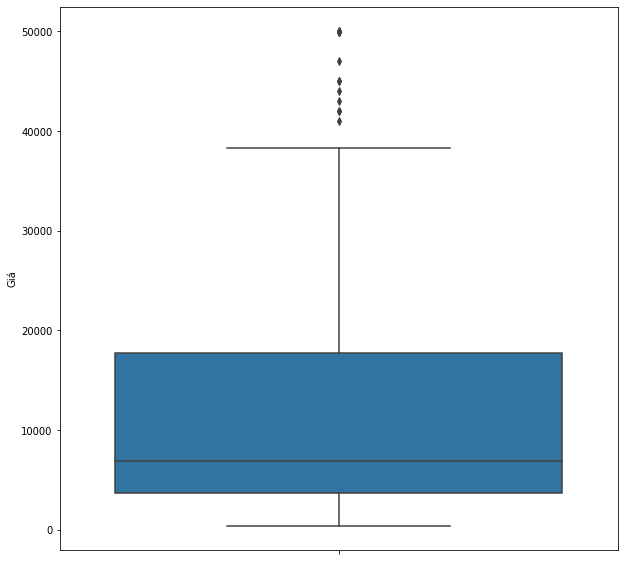

In [ ]:
plt.clf()
fig, ax = plt.subplots(figsize=(10, 10))
sns.boxplot(y = 'Giá', data = df_buoc3, ax = ax)
plt.xticks(rotation = 90)

In [ ]:
# Giá điện thoại tập trung nhiều nhất ở khoảng giá nào?
q3, q1 = np.percentile(df_buoc3['Giá'], [75 ,25])
print(q3)
print(q1)

17740.0
3690.0


## Kích thước màn hình

In [ ]:
KiemTraThuocTinh(df_buoc3, 'Kích thước màn hình')


- Thuộc tính Kích thước màn hình có tổng cộng 266 dòng.

- Số điểm dữ liệu null: 126 

- Số lượng dữ liệu độc nhất:  31
- Các dữ liệu độc nhất (unique):
[ nan 7.6  6.1  6.67 6.5  6.43 6.51 6.55 6.7  7.59 5.4  6.8  6.81 6.56
 6.2  4.7  6.44 6.4  6.58 6.6  6.49 6.53 6.52 6.82 6.39 2.8  2.4  5.5
 1.8  2.2  1.77]


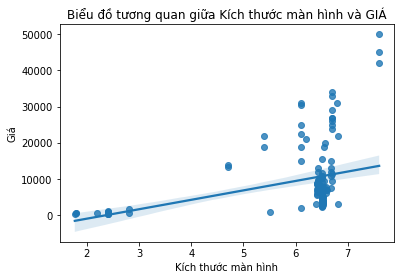

In [ ]:
sns.regplot(x=df_buoc3['Kích thước màn hình'],y=df_buoc3["Giá"]).set(title='Biểu đồ tương quan giữa ' + str('Kích thước màn hình') + " và GIÁ")
plt.show()

Nhìn vào biểu đồ ta có thể thấy, sự thay đổi của _'Kích thước màn hình'_ có thể dẫn đến sự thay đổi của giá.

## Công nghệ màn hình


In [ ]:
KiemTraThuocTinh(df_buoc3, 'Công nghệ màn hình')


- Thuộc tính Công nghệ màn hình có tổng cộng 266 dòng.

- Số điểm dữ liệu null: 24 

- Số lượng dữ liệu độc nhất:  14
- Các dữ liệu độc nhất (unique):
['Dynamic AMOLED' 'TFT LCD' 'AMOLED' nan 'OLED'
 '300nits chống chói, 165Hz, 100% sRGB, Dolby Vision, G-Sync, DC dimmer'
 'Super AMOLED' 'IPS LCD' 'PLS TFT LCD' 'Dynamic AMOLED 2X' 'PLS LCD'
 'Chính: Dynamic AMOLED 2X, Phụ: Super AMOLED' 'Super AMOLED Plus' 'LCD']


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
 <a list of 13 Text major ticklabel objects>)

<Figure size 432x288 with 0 Axes>

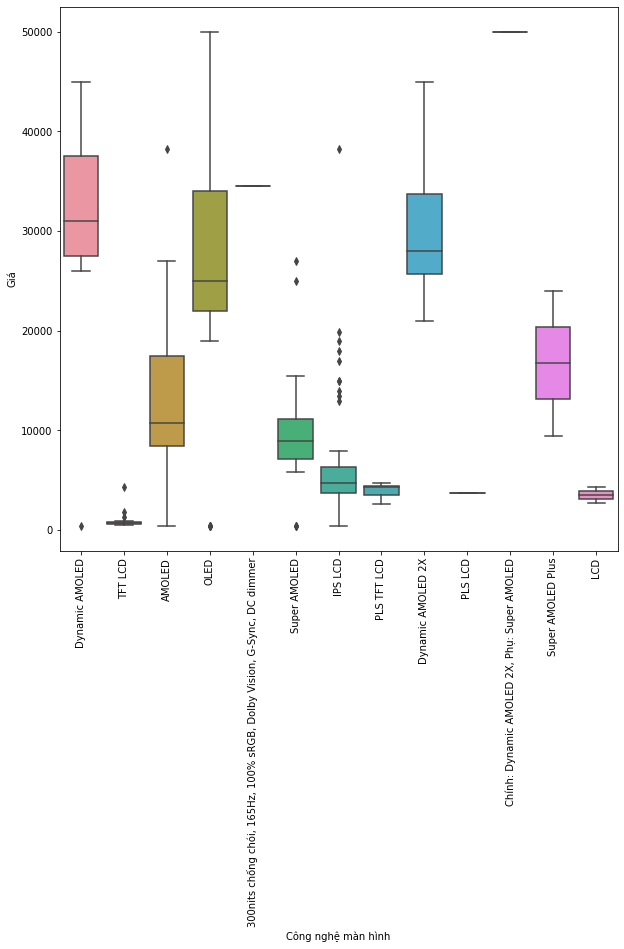

In [ ]:
plt.clf()
fig, ax = plt.subplots(figsize=(10, 10))
sns.boxplot(x = 'Công nghệ màn hình',y = 'Giá', data = df_buoc3, ax = ax)
plt.xticks(rotation = 90)

Qua biểu đồ có thể thấy, những chiếc điện thoại không có cụ thể công nghệ màn hình thường tập trung ở mức giá thấp nhất. <br>
Một số công nghệ màn hình khác cũng tập trung ở tầm giá thấp là: _Super AMOLED, IPS LCD, PLS TFT LCD, LCD_. <br>
Một số máy có công nghệ _Dynamic AMOLED, Dynamic AMOLED 2X, OLED_ có mức giá nằm cao hơn trung bình.

Các công nghệ khác nhau làm dẫn đến mức giá chênh lệch nhau.

Vậy sinh viên cho rằng thuộc tính __công nghệ màn hình__ có ảnh hưởng đến kết quả đầu ra.

## Camera sau

In [ ]:
KiemTraThuocTinh(df_buoc3, 'Camera sau')


- Thuộc tính Camera sau có tổng cộng 266 dòng.

- Số điểm dữ liệu null: 14 

- Số lượng dữ liệu độc nhất:  121
- Các dữ liệu độc nhất (unique):
['Ống kính chính góc rộng: 108MP, f/1.8 Ống kính zoom tiềm vọng: 10MP, zoom quang 10x Cảm biến tele: 10MP, zoom quang 3x Cảm biến siêu rộng: 12MP, f/2.2 Cảm biến Laser AF'
 'Camera góc rộng: 48 MP, f/2.0, 26mm, AF Camera góc siêu rộng: 5 MP, f/2.2, 123˚ Camera chụp cận cảnh: 2 MP, f/2.4 Camera xóa phông: 2 MP, f/2.4'
 '- Cảm biến chính (góc rộng) 12 MP, f/1.8, chống rung quang học OIS - Cảm biến tele 64 MP, f/2.0, zoom quang 1.1x, zoom lai 3x - Cảm biến góc cực rộng 12 MP, f/2.2'
 'Camera góc rộng: 108MP, f/1.75 Camera góc siêu rộng: 8MP ultra-wide, 120° FOV f/2.2 Camera cận cảnh: 5 MP, f/2.4 AF (3cm-7cm)'
 'Camera chính: 64MP, f/1.79, 6P Camera góc siêu rộng: 8MP, f/2.2 Camera tele: 5MP, f/2.4, Contrast AF (3cm-7cm)'
 'Camera chính: 12 MP, f/1.8, 26mm (wide), 1/1.76", 1.8µm, Dual Pixel PDAF, OIS Camera ra tele: 12 MP, f/2.4, 52mm (telephoto),

Ý nghĩa của các giá trị: {'- Camera chính góc rộng 64 MP, f/1.8, lấy nét theo pha kép PDAF - Camera góc siêu rộng 13 MP, f/2.4, 125˚ - Camera macro 5 MP, f/2.0': 0, '- Cảm biến chính (góc rộng) 12 MP, f/1.8, chống rung quang học OIS - Cảm biến tele 64 MP, f/2.0, zoom quang 1.1x, zoom lai 3x - Cảm biến góc cực rộng 12 MP, f/2.2': 1, '0.08 MP': 2, '0.3 MP': 3, '0.8 MP': 4, '108 MP, f/1.8, 26mm (wide), 1/1.33", 0.8µm, PDAF, Laser AF, OIS 12 MP, f/3.0, 103mm (periscope telephoto), 1.0µm, PDAF, OIS, 5x optical zoom, 50x hybrid zoom 12 MP, f/2.2, 13mm (ultrawide), 1/2.55", 1.4µm': 5, '12 MP': 6, '12 MP, f/1.6, 26mm (wide), 1.4µm, dual pixel PDAF, OIS 12 MP, f/2.0, 52mm (telephoto), 1/3.4", 1.0µm, PDAF, OIS, 2x optical zoom 12 MP, f/2.4, 120˚, 13mm (ultrawide), 1/3.6" TOF 3D LiDAR scanner (depth)': 7, '12 MP, f/1.6, 26mm (wide), 1.4µm, dual pixel PDAF, OIS 12 MP, f/2.4, 120˚, 13mm (ultrawide), 1/3.6"': 8, '12MP': 9, '13 MP + 2 MP': 10, '13 MP, 4128 x 3096 pixels, ổn định hình ảnh quang học, t

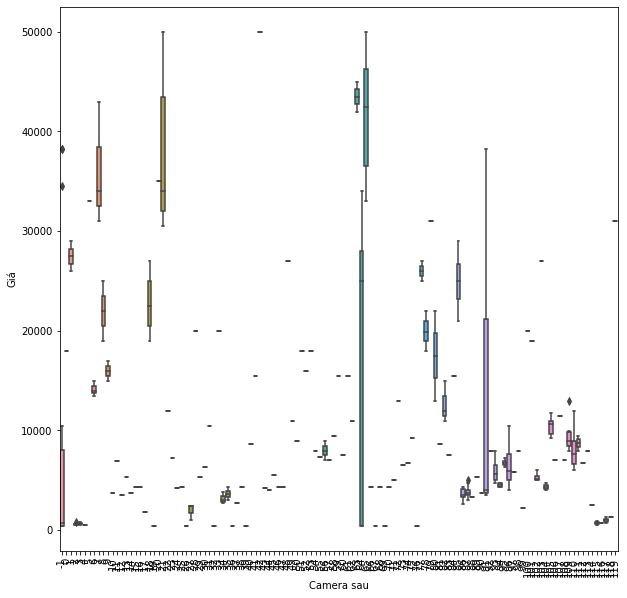

In [ ]:
# Ve_BoxPlot_BienPhanLoai_vs_Gia(df_buoc3, 'Camera sau')
df_encode, encoder, dict_data =encode(df_buoc3[['Camera sau']])
fig, ax = plt.subplots(figsize=(10, 10))
sns.boxplot(x = df_encode.iloc[:,0],y = df_buoc3["Giá"])
print("Ý nghĩa của các giá trị:", dict_data)
plt.xticks(rotation = 90)
plt.show()

Nhiều quá khó phân tích. Với lại những thuộc tính có nhiều giá trị thường xuất hiện nhiều giá trị đơn, trong khi boxplot biểu thị distribution của một giá trị cụ thể nên t thấy không có nhiều ý nghĩa lắm.

## Camera trước

In [ ]:
KiemTraThuocTinh(df_buoc3, 'Camera trước')


- Thuộc tính Camera trước có tổng cộng 266 dòng.

- Số điểm dữ liệu null: 33 

- Số lượng dữ liệu độc nhất:  31
- Các dữ liệu độc nhất (unique):
['40MP' '8MP' '10MP' '16MP' '20MP' '10 MP & 10 MP' '12MP' '4MP' nan '32MP'
 '24MP' '7MP' '5MP' '13MP' '10 MP & 4 MP' '12 MP' '16 MP' '5 MP' '32 MP'
 '13 MP' '8 MP' 'Trong 10 MP & Ngoài 10 MP' '10 MP' '40 MP' '20 MP' '7 MP'
 '44 MP' 'Chính 16 MP & Phụ 8 MP' 'Chính 16 MP & Phụ 2 MP' '2 MP'
 'VGA (0.3 MP)']


In [ ]:
#Ve_BoxPlot_BienPhanLoai_vs_Gia(df_buoc3, 'Camera trước')


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
 <a list of 30 Text major ticklabel objects>)

<Figure size 432x288 with 0 Axes>

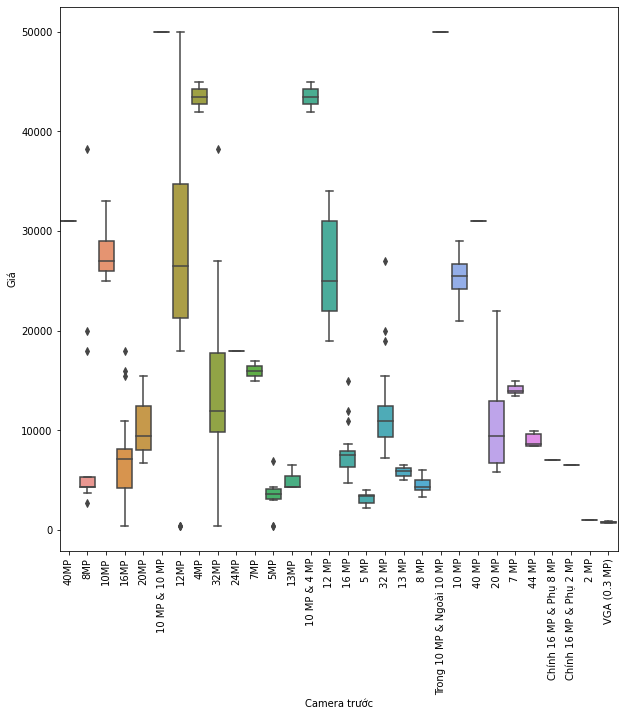

In [ ]:
plt.clf()
fig, ax = plt.subplots(figsize=(10, 10))
sns.boxplot(x = 'Camera trước',y = 'Giá', data = df_buoc3, ax = ax)
plt.xticks(rotation = 90)

Biểu đồ cho thấy đa số các điện thoại có đa dạng chất lượng camera ở đa dạng các mệnh giá như các điện thoại chất lượng camera thấp nhưng có giá cao như 4MP, 10MP, ... và ngược lại như 20MP, 44MP.

Do đó có thể suy luận rằng Camera trước chỉ ảnh hưởng rất nhỏ đến giá tiền.

## CPU

In [ ]:
KiemTraThuocTinh(df_buoc3, 'CPU')


- Thuộc tính CPU có tổng cộng 266 dòng.

- Số điểm dữ liệu null: 24 

- Số lượng dữ liệu độc nhất:  108
- Các dữ liệu độc nhất (unique):
['Exynos 2100 8 nhân' 'Helio G35' 'MediaTek Dimensity 1200-Ultra'
 'Snapdragon™ 778G' 'Qualcomm SM8250 Snapdragon 865+ (7 nm+)' 'Apple A15'
 'Snapdragon 888 5G (5 nm)' 'Apple A14 Bionic (5 nm)' 'A13 Bionic' nan
 'Apple A15 Bionic 6 nhân' 'Snapdragon 888 8 (5nm)'
 'Snapdragon 888 (5 nm)' 'Exynos 990 (7 nm+)'
 'Qualcomm Snapdragon 865+ (7nm+)' 'SM8350 Snapdragon 888 5G (5 nm)'
 'Dimensity 1200' 'Qualcomm Snapdragon 888 5nm'
 'Qualcomm SM8350 Snapdragon 888 (5 nm)' 'Apple A12 Bionic'
 'MT6877 Dimensity 900 5G (6 nm)' 'Snapdragon 865'
 'Snapdragon 778G 5G 8 nhân' 'Qualcomm SM7125 Snapdragon 720G (8 nm)'
 'MediaTek Dimensity 800U 5G 8 nhân'
 'Qualcomm Snapdragon 780G  Tiến trình 5nm' 'Snapdragon 720G (8 nm)'
 'Qualcomm Snapdragon 750G, tối đa 2.2GHz' 'Qualcomm® Snapdragon™ 720G'
 'Snapdragon 732G (8 nm)' 'MediaTek Dimensity 700 5G 8 nhân'
 'MediaTek Dimen

Ý nghĩa của các giá trị: {'A13 Bionic': 0, 'Apple A12 Bionic': 1, 'Apple A12 Bionic 6 nhân': 2, 'Apple A13 Bionic 6 nhân': 3, 'Apple A14 Bionic (5 nm)': 4, 'Apple A14 Bionic 6 nhân': 5, 'Apple A15': 6, 'Apple A15 Bionic 6 nhân': 7, 'Dimensity 1200': 8, 'Exynos 2100 8 nhân': 9, 'Exynos 850 8 nhân': 10, 'Exynos 9611': 11, 'Exynos 9611 8 nhân': 12, 'Exynos 990 (7 nm+)': 13, 'Exynos 990 8 nhân': 14, 'Helio G35': 15, 'Helio G80': 16, 'Helio G80 (12 nm)': 17, 'Helio P35 (MTK6765)': 18, 'MT6877 Dimensity 900 5G (6 nm)': 19, 'MediaTek Dimensity 1200': 20, 'MediaTek Dimensity 1200 8 nhân': 21, 'MediaTek Dimensity 1200-Ultra': 22, 'MediaTek Dimensity 2000 4nm': 23, 'MediaTek Dimensity 700 5G 8 nhân': 24, 'MediaTek Dimensity 700 8 nhân': 25, 'MediaTek Dimensity 800U 5G 8 nhân': 26, 'MediaTek Dimensity 900 5G': 27, 'MediaTek G70': 28, 'MediaTek Helio G35': 29, 'MediaTek Helio G35 (12 nm)': 30, 'MediaTek Helio G35 8 nhân': 31, 'MediaTek Helio G35, tối đa 2.5 GHz': 32, 'MediaTek Helio G70 8 nhân': 3

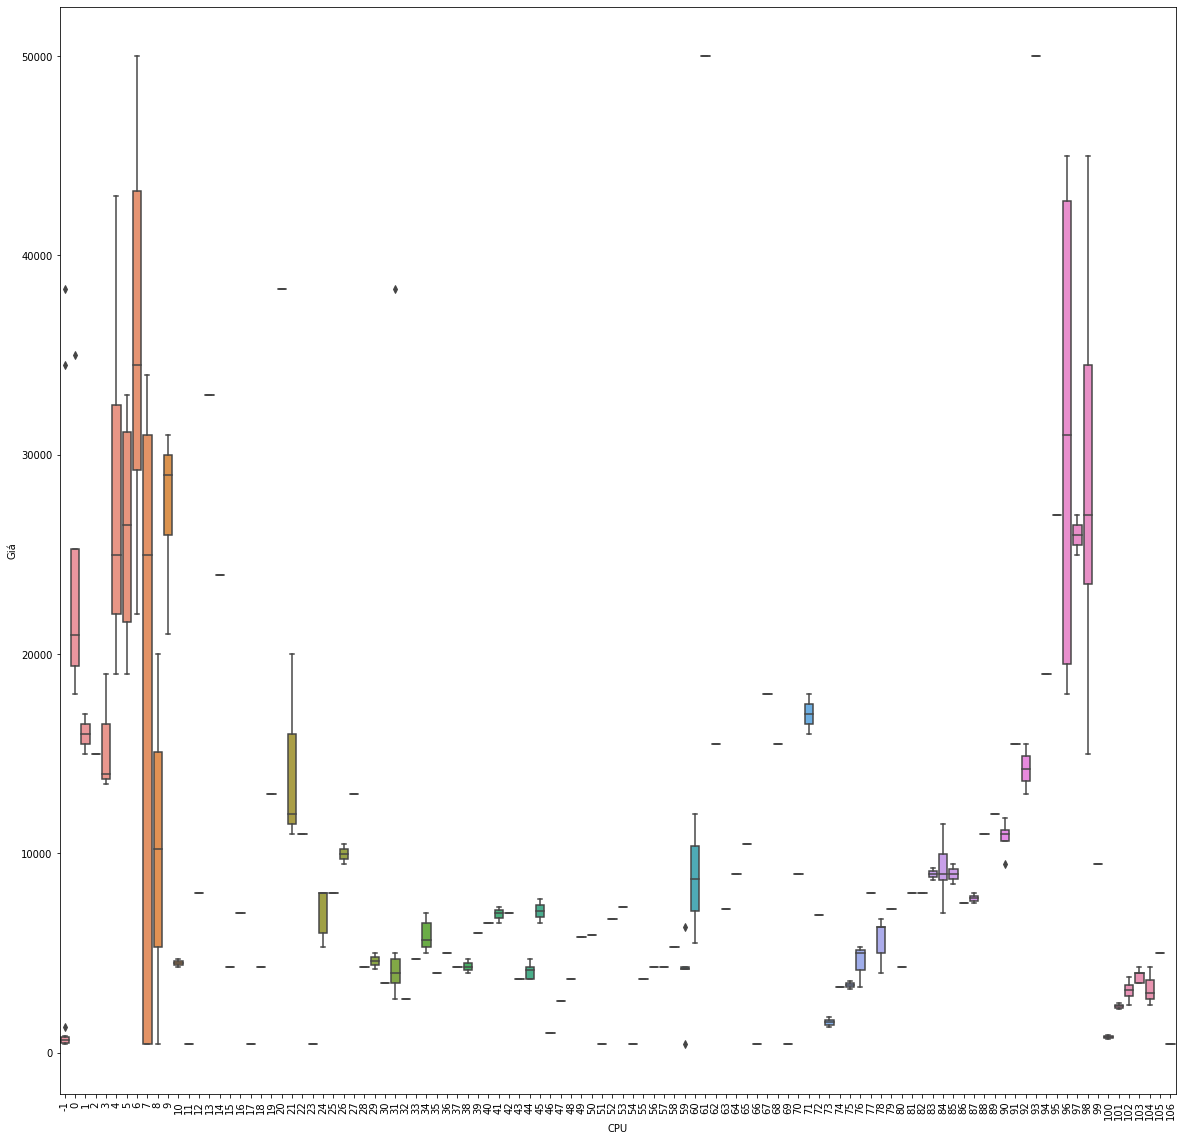

In [ ]:
df_encode, encoder, dict_data =encode(df_buoc3[['CPU']])
fig, ax = plt.subplots(figsize=(20, 20))
sns.boxplot(x = df_encode.iloc[:,0],y = df_buoc3["Giá"])
print("Ý nghĩa của các giá trị:", dict_data)
plt.xticks(rotation = 90)
plt.show()

In [ ]:
dict_data

{'A13 Bionic': 0,
 'Apple A12 Bionic': 1,
 'Apple A12 Bionic 6 nhân': 2,
 'Apple A13 Bionic 6 nhân': 3,
 'Apple A14 Bionic (5 nm)': 4,
 'Apple A14 Bionic 6 nhân': 5,
 'Apple A15': 6,
 'Apple A15 Bionic 6 nhân': 7,
 'Dimensity 1200': 8,
 'Exynos 2100 8 nhân': 9,
 'Exynos 850 8 nhân': 10,
 'Exynos 9611': 11,
 'Exynos 9611 8 nhân': 12,
 'Exynos 990 (7 nm+)': 13,
 'Exynos 990 8 nhân': 14,
 'Helio G35': 15,
 'Helio G80': 16,
 'Helio G80 (12 nm)': 17,
 'Helio P35 (MTK6765)': 18,
 'MT6877 Dimensity 900 5G (6 nm)': 19,
 'MediaTek Dimensity 1200': 20,
 'MediaTek Dimensity 1200 8 nhân': 21,
 'MediaTek Dimensity 1200-Ultra': 22,
 'MediaTek Dimensity 2000 4nm': 23,
 'MediaTek Dimensity 700 5G 8 nhân': 24,
 'MediaTek Dimensity 700 8 nhân': 25,
 'MediaTek Dimensity 800U 5G 8 nhân': 26,
 'MediaTek Dimensity 900 5G': 27,
 'MediaTek G70': 28,
 'MediaTek Helio G35': 29,
 'MediaTek Helio G35 (12 nm)': 30,
 'MediaTek Helio G35 8 nhân': 31,
 'MediaTek Helio G35, tối đa 2.5 GHz': 32,
 'MediaTek Helio G70 8 

## Dung lượng RAM

In [ ]:
KiemTraThuocTinh(df_buoc3, 'Dung lượng RAM')


- Thuộc tính Dung lượng RAM có tổng cộng 266 dòng.

- Số điểm dữ liệu null: 139 

- Số lượng dữ liệu độc nhất:  9
- Các dữ liệu độc nhất (unique):
[nan '12 GB' '4 GB' '8 GB' '6 GB' '3 GB' '2 GB' '512 MB' '1 GB']


In [ ]:
df_buoc3['Dung lượng RAM']=df_buoc3['Dung lượng RAM'].str.replace("8GB","8 GB")

<Figure size 432x288 with 0 Axes>

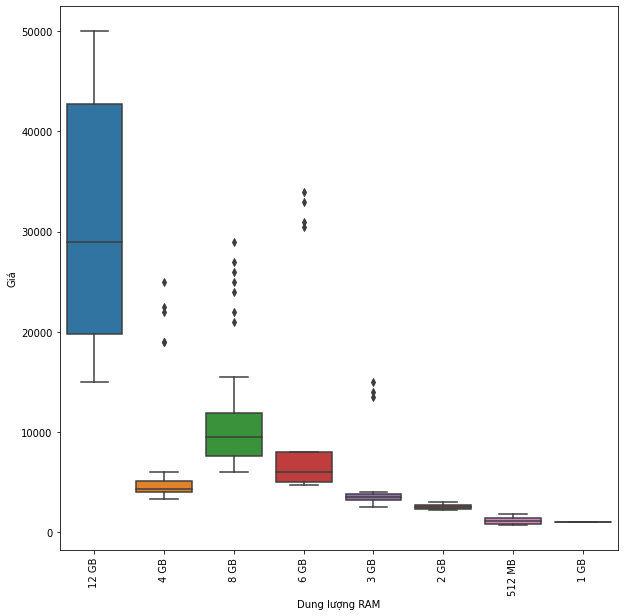

In [ ]:
Ve_BoxPlot_BienPhanLoai_vs_Gia(df_buoc3, 'Dung lượng RAM')

Biểu đồ này cho thấy được mối tương quan thuận giữa dung lượng RAM và giá tiền điện thoại nên có thể kết luận rằng dung lượng RAM ảnh hưởng đến kết quả đầu ra

## Bộ nhớ trong

In [ ]:
KiemTraThuocTinh(df_buoc3, 'Bộ nhớ trong')


- Thuộc tính Bộ nhớ trong có tổng cộng 266 dòng.

- Số điểm dữ liệu null: 139 

- Số lượng dữ liệu độc nhất:  8
- Các dữ liệu độc nhất (unique):
[nan '512 GB' '64 GB' '128 GB' '256 GB' '32 GB' '4 GB' '8 GB']


<Figure size 432x288 with 0 Axes>

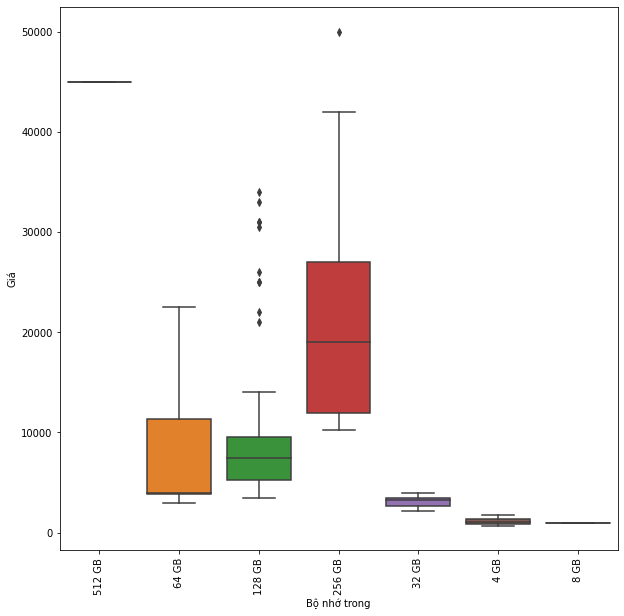

In [ ]:
Ve_BoxPlot_BienPhanLoai_vs_Gia(df_buoc3, 'Bộ nhớ trong')

Biểu đồ này thể hiện rõ sự tương quan thuận giữa 2 biến Bộ nhớ trong và giá tiền.

Vậy có thể kết luận rằng Bộ nhớ trong có ảnh hưởng đến giá tiền.

## Thẻ SIM

In [ ]:
KiemTraThuocTinh(df_buoc3, 'Thẻ SIM')


- Thuộc tính Thẻ SIM có tổng cộng 266 dòng.

- Số điểm dữ liệu null: 16 

- Số lượng dữ liệu độc nhất:  12
- Các dữ liệu độc nhất (unique):
['2 SIM (Nano-SIM)' 'Nano-SIM' '2 SIM (nano‑SIM và eSIM)'
 'Nano-SIM + eSIM' nan '2 Nano SIM' '1 Nano SIM & 1 eSIM'
 '2 Nano SIM hoặc 1 Nano SIM + 1 eSIM'
 '2 Nano SIM (SIM 2 chung khe thẻ nhớ)' '2 Micro SIM' '2 SIM thường'
 '1 Micro SIM & 1 SIM thường']


<Figure size 432x288 with 0 Axes>

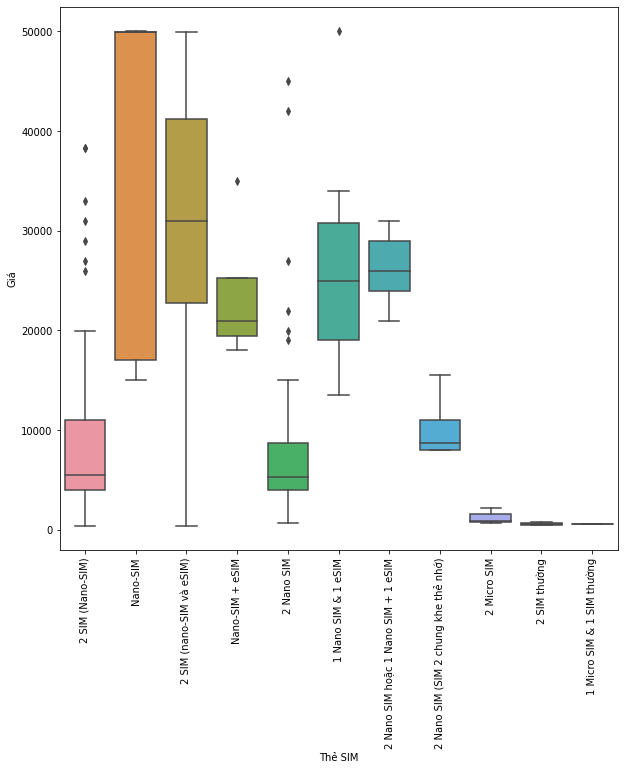

In [ ]:
Ve_BoxPlot_BienPhanLoai_vs_Gia(df_buoc3, 'Thẻ SIM')


Qua biểu đồ này có thể thấy, những điện thoại có SIM thường và Micro SIM đều có mệnh giá thấp, còn 2 loại eSIM và NanoSIM đều có mệnh giá cao hơn nhưng không nhận ra sự chênh lệch đáng kể nào giữa 2 loại SIM này.

Từ đây có thể rút ra kết luận rằng Thẻ SIM ít có ảnh hưởng đến đầu ra

## Hệ điều hành

In [ ]:
KiemTraThuocTinh(df_buoc3, 'Hệ điều hành')


- Thuộc tính Hệ điều hành có tổng cộng 266 dòng.

- Số điểm dữ liệu null: 23 

- Số lượng dữ liệu độc nhất:  53
- Các dữ liệu độc nhất (unique):
['Android 11, One UI 3.0' 'Android 10' 'Android 11, MIUI 12.5'
 'MIUI 12.5, Android 11' 'Android 10, One UI 2.5' 'iOS15' 'Android 11'
 'iOS 14.1 hoặc cao hơn (Tùy vào phiên bản phát hành)'
 'iOS 13 hoặc cao hơn (Tùy vào phiên bản phát hành)' 'Windows 10 Home'
 'iOS 15' 'ColorOS 11.2, nền tảng Android 11' 'Android 10, One UI 2.1'
 'Android 10, ROG UI' 'Android 11, Redmagic 4.0'
 'Android 11, Funtouch OS 12 (phiên bản quốc tế)' 'iOS 12'
 'Android 11, ColorOS 11.3' 'iOS 14' 'Android 11, One UI 3.1'
 'ColorOS 7.2, nền tảng Android 10' 'ColorOS 11.3, nền tảng Android 11'
 nan 'Android 11, Realme UI 2.0' 'Android 11, OxygenOS 11'
 'realme UI 1.0 - Android 10' 'Android 11, MIUI 12'
 'Android 11, Funtouch 11.1' 'v5.1.1 (Lollipop)'
 'Android 11, Funtouch OS 11.1' 'Android 10, Realme UI'
 'Android 10, OxygenOS 10.5' 'Android 11, Realme UI R'
 'Android 

Ý nghĩa của các giá trị: {'9': 0, 'Android 10': 1, 'Android 10 (Android One)': 2, 'Android 10 (Go Edition)': 3, 'Android 10, EMUI 10.1, no Google Play Services': 4, 'Android 10, MIUI 11': 5, 'Android 10, MIUI 12': 6, 'Android 10, One UI 2.1': 7, 'Android 10, One UI 2.5': 8, 'Android 10, OxygenOS 10.5': 9, 'Android 10, ROG UI': 10, 'Android 10, Realme UI': 11, 'Android 10, VOS 3.0': 12, 'Android 10, giao diện ColorOS 7.2': 13, 'Android 10.0 (Go edition)': 14, 'Android 11': 15, 'Android 11 (Go Edition)': 16, 'Android 11, ColorOS 11.1': 17, 'Android 11, ColorOS 11.3': 18, 'Android 11, Funtouch 11': 19, 'Android 11, Funtouch 11.1': 20, 'Android 11, Funtouch OS 11.1': 21, 'Android 11, Funtouch OS 12 (phiên bản quốc tế)': 22, 'Android 11, MIUI 12': 23, 'Android 11, MIUI 12.5': 24, 'Android 11, One UI 3.0': 25, 'Android 11, One UI 3.1': 26, 'Android 11, OxygenOS 11': 27, 'Android 11, Realme UI 2.0': 28, 'Android 11, Realme UI R': 29, 'Android 11, Redmagic 4.0': 30, 'Android 8 (Oreo)': 31, 'An

<Figure size 432x288 with 0 Axes>

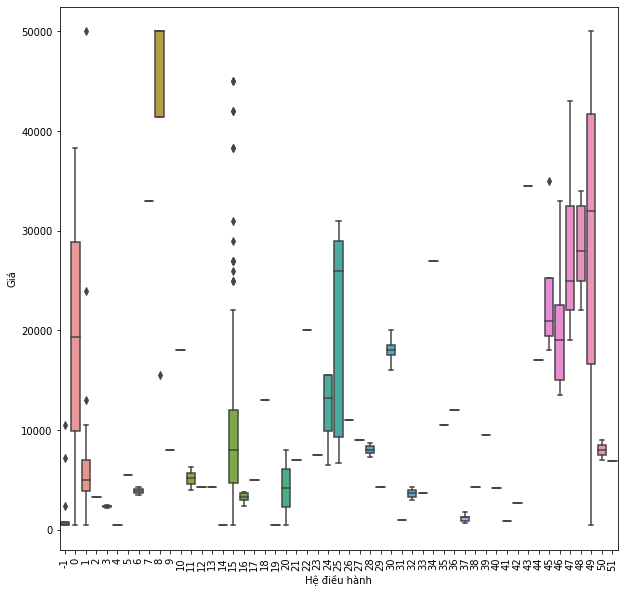

In [ ]:
Ve_BoxPlot_BienPhanLoai_vs_Gia(df_buoc3, 'Hệ điều hành')


Qua biểu đồ ta nhận thấy các dòng điện thoại IOS có mức giá cao nhất như IOS14, IOS15; các dòng điện thoại Android 11 và thấp nhất là dòng Android 10. 

Như vậy có thể kết luận được rằng Hệ điều hành có ảnh hưởng đến giá tiền.

## Độ phân giải màn hình

In [ ]:
KiemTraThuocTinh(df_buoc3, 'Độ phân giải màn hình')


- Thuộc tính Độ phân giải màn hình có tổng cộng 266 dòng.

- Số điểm dữ liệu null: 18 

- Số lượng dữ liệu độc nhất:  33
- Các dữ liệu độc nhất (unique):
['1440 x 3200' '720 x 1560' '1080 x 2400' '1768 x 2208' '2778 x 1284' nan
 '1170 x 2532' '1284 x 2778' '2688 x 1242' '1080 x 1920' '2532 x 1170'
 '1080 x 2340' '1440 x 3216' '1440 x 3088' '1792 x 828' '1080 x 2376'
 '720 x 1600' '720 x 1520' '1920 x 1080' '750 x 1560' '240 x 320'
 '120 x 160' '720 x 1480' '1080 x 2640' '3216 x 1440' '828 x 1792'
 '1080 x 2440' '750 x 1334' '1080 x 2408' '700 x 1600' '480 x 960'
 'Q 120 x 160' '176 x 220']


Ý nghĩa của các giá trị: {'1080 x 1920': 0, '1080 x 2340': 1, '1080 x 2376': 2, '1080 x 2400': 3, '1080 x 2408': 4, '1080 x 2440': 5, '1080 x 2640': 6, '1170 x 2532': 7, '120 x 160': 8, '1284 x 2778': 9, '1440 x 3088': 10, '1440 x 3200': 11, '1440 x 3216': 12, '176 x 220': 13, '1768 x 2208': 14, '1792 x 828': 15, '1920 x 1080': 16, '240 x 320': 17, '2532 x 1170': 18, '2688 x 1242': 19, '2778 x 1284': 20, '3216 x 1440': 21, '480 x 960': 22, '700 x 1600': 23, '720 x 1480': 24, '720 x 1520': 25, '720 x 1560': 26, '720 x 1600': 27, '750 x 1334': 28, '750 x 1560': 29, '828 x 1792': 30, 'Q 120 x 160': 31, nan: -1}


<Figure size 432x288 with 0 Axes>

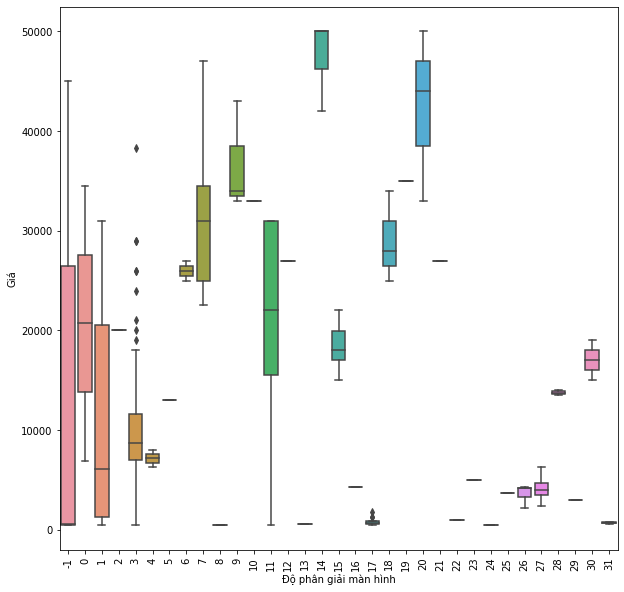

In [ ]:
Ve_BoxPlot_BienPhanLoai_vs_Gia(df_buoc3, 'Độ phân giải màn hình')

Có thể thấy rằng những điện thoại có độ phân giải dưới 1000 có giá rất thấp. Những dòng điện thoại có độ phân giải cao hơn có sự đa dạng về giá, nhưng nhìn chung những điện thoại có độ phân giải trên 2000 có giá cao hơn mức trung bình.

Như vậy có thể thấy rằng Độ phân giải màn hình có ảnh hưởng đến kết quả đầu ra.

In [ ]:
df_encode, encoder, dict_data =encode(df_buoc3[['Độ phân giải màn hình']])
dict_data

{'1080 x 1920': 0,
 '1080 x 2340': 1,
 '1080 x 2376': 2,
 '1080 x 2400': 3,
 '1080 x 2408': 4,
 '1080 x 2440': 5,
 '1080 x 2640': 6,
 '1170 x 2532': 7,
 '120 x 160': 8,
 '1284 x 2778': 9,
 '1440 x 3088': 10,
 '1440 x 3200': 11,
 '1440 x 3216': 12,
 '176 x 220': 13,
 '1768 x 2208': 14,
 '1792 x 828': 15,
 '1920 x 1080': 16,
 '240 x 320': 17,
 '2532 x 1170': 18,
 '2688 x 1242': 19,
 '2778 x 1284': 20,
 '3216 x 1440': 21,
 '480 x 960': 22,
 '700 x 1600': 23,
 '720 x 1480': 24,
 '720 x 1520': 25,
 '720 x 1560': 26,
 '720 x 1600': 27,
 '750 x 1334': 28,
 '750 x 1560': 29,
 '828 x 1792': 30,
 'Q 120 x 160': 31,
 nan: -1}

## Loại CPU

In [ ]:
KiemTraThuocTinh(df_buoc3, 'Loại CPU')


- Thuộc tính Loại CPU có tổng cộng 266 dòng.

- Số điểm dữ liệu null: 51 

- Số lượng dữ liệu độc nhất:  93
- Các dữ liệu độc nhất (unique):
['8 nhân: 1 nhân Cortex-X1 tốc độ 2.9GHz, 3 nhân Cortex-A78 tốc độ 2.8GHz, 4 nhân Cortex-A55 tốc độ 2.2GHz'
 '8 nhân (2.3 GHz, 1.8 GHz)'
 '8 nhân (1x2.84 GHz Kryo 585 3x2.42 GHz Kryo 585 4x1.80 GHz Kryo 585)'
 'Qualcomm® Kryo™ 670, octa-core CPU, up to 2.4GHz'
 'Octa-core (1x3.09 GHz Kryo 585 3x2.42 GHz Kryo 585 4x1.8 GHz Kryo 585)'
 nan '1 nhân 2.84 GHz, 3 nhân 2.42 GHz 4 nhân 1.8 GHz' 'Hexa-core'
 'Intel Core i7-11800H 2.3GHz up to 4.6GHz 24MB'
 '8 nhân (1x2.84 GHz Kryo 680 3x2.42 GHz Kryo 680 4x1.80 GHz Kryo 680)'
 'Octa-core (2x2.73 GHz Mongoose M5 2x2.50 GHz Cortex-A76 4x2.0 GHz Cortex-A55)'
 'Octa-core (1x3.1 GHz Kryo 585 3x2.42 GHz Kryo 585 4x1.8 GHz Kryo 585)'
 '6 nhân: 2 nhân Lightning 2.65GHz 4 nhân Thunder 1.8GHz'
 '1x2.84 GHz Kryo 680 3x2.42 GHz Kryo 680 4x1.80 GHz Kryo 680'
 '1x2.8 GHz Cortex-A78 3x2.6 GHz Cortex-A78 4x2.0 GHz Cortex

Ý nghĩa của các giá trị: {'1 nhân 2.4 GHz, 1 nhân 2.2 GHz & 6 nhân 1.8 GHz': 0, '1 nhân 2.4 GHz, 3 nhân 2.2 GHz & 4 nhân 1.9 GHz': 1, '1 nhân 2.4 GHz, 3 nhân 2.2 GHz 4 nhân 1.9 GHz': 2, '1 nhân 2.84 GHz, 3 nhân 2.42 GHz & 4 nhân 1.8 GHz': 3, '1 nhân 2.84 GHz, 3 nhân 2.42 GHz 4 nhân 1.8 GHz': 4, '1 nhân 2.9 GHz, 3 nhân 2.8 GHz & 4 nhân 2.2 GHz': 5, '1 nhân 3 GHz, 3 nhân 2.6 GHz & 4 nhân 2 GHz': 6, '1 nhân 3.09 Ghz & 3 nhân 2.4 Ghz & 4 nhân 1.8 Ghz': 7, '1 nhân 3.2 GHz & 3 nhân 2.42 & 4 nhân 1.8 GHz': 8, '1.3 GHz': 9, '1.4 GHz': 10, '1.8 GHz': 11, '1x2.8 GHz Cortex-A78 3x2.6 GHz Cortex-A78 4x2.0 GHz Cortex-A55': 12, '1x2.84 GHz Kryo 680 3x2.42 GHz Kryo 680 4x1.80 GHz Kryo 680': 13, '2 nhân 1.95 GHz & 6 nhân 1.45 GHz': 14, '2 nhân 2.0 GHz & 6 nhân 1.7 GHz': 15, '2 nhân 2.0 GHz & 6 nhân 1.8 GHz': 16, '2 nhân 2.0 GHz 6 nhân 1.7 GHz': 17, '2 nhân 2.0 GHz 6 nhân 1.8 GHz': 18, '2 nhân 2.05 GHz & 6 nhân 2.0 GHz': 19, '2 nhân 2.05 GHz 6 nhân 2.0 GHz': 20, '2 nhân 2.2 GHz & 6 nhân 1.8 GHz': 21, '

<Figure size 432x288 with 0 Axes>

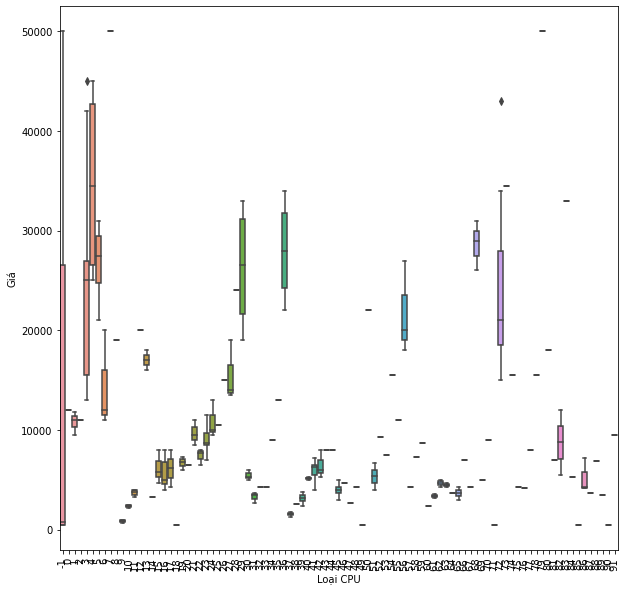

In [ ]:
Ve_BoxPlot_BienPhanLoai_vs_Gia(df_buoc3, 'Loại CPU')

In [ ]:
df_encode, encoder, dict_data =encode(df_buoc3[['Loại CPU']])
dict_data

{'1 nhân 2.4 GHz, 1 nhân 2.2 GHz & 6 nhân 1.8 GHz': 0,
 '1 nhân 2.4 GHz, 3 nhân 2.2 GHz & 4 nhân 1.9 GHz': 1,
 '1 nhân 2.4 GHz, 3 nhân 2.2 GHz 4 nhân 1.9 GHz': 2,
 '1 nhân 2.84 GHz, 3 nhân 2.42 GHz & 4 nhân 1.8 GHz': 3,
 '1 nhân 2.84 GHz, 3 nhân 2.42 GHz 4 nhân 1.8 GHz': 4,
 '1 nhân 2.9 GHz, 3 nhân 2.8 GHz & 4 nhân 2.2 GHz': 5,
 '1 nhân 3 GHz, 3 nhân 2.6 GHz & 4 nhân 2 GHz': 6,
 '1 nhân 3.09 Ghz & 3 nhân 2.4 Ghz & 4 nhân 1.8 Ghz': 7,
 '1 nhân 3.2 GHz & 3 nhân 2.42 & 4 nhân 1.8 GHz': 8,
 '1.3 GHz': 9,
 '1.4 GHz': 10,
 '1.8 GHz': 11,
 '1x2.8 GHz Cortex-A78 3x2.6 GHz Cortex-A78 4x2.0 GHz Cortex-A55': 12,
 '1x2.84 GHz Kryo 680 3x2.42 GHz Kryo 680 4x1.80 GHz Kryo 680': 13,
 '2 nhân 1.95 GHz & 6 nhân 1.45 GHz': 14,
 '2 nhân 2.0 GHz & 6 nhân 1.7 GHz': 15,
 '2 nhân 2.0 GHz & 6 nhân 1.8 GHz': 16,
 '2 nhân 2.0 GHz 6 nhân 1.7 GHz': 17,
 '2 nhân 2.0 GHz 6 nhân 1.8 GHz': 18,
 '2 nhân 2.05 GHz & 6 nhân 2.0 GHz': 19,
 '2 nhân 2.05 GHz 6 nhân 2.0 GHz': 20,
 '2 nhân 2.2 GHz & 6 nhân 1.8 GHz': 21,
 '2 n

##GPU

In [ ]:
df_GPU_encode,encoder_GPU,dict_GPU=encode(df_buoc3[["GPU"]])
df_GPU_encode

,GPU
0,19
1,46
2,42
3,42
4,11
...,...
261,-1
262,-1
263,-1
264,-1


In [ ]:
print('Chuyển đổi giữa giá trị gốc và giá trị số đối với cột GPU')
df_GPU = pd.DataFrame(data={
    'Giá trị gốc': list(dict_GPU.keys()),
    "Numeric": list(dict_GPU.values())
})
df_GPU.to_excel('Encoder_GPU.xlsx')
df_GPU

Chuyển đổi giữa giá trị gốc và giá trị số đối với cột GPU


,Giá trị gốc,Numeric
0,ARM G76,0
1,ARM Mali-G52,1
2,Adreno 304,2
3,Adreno 505,3
4,Adreno 506,4
5,Adreno 610,5
6,Adreno 612,6
7,Adreno 618,7
8,Adreno 619,8
9,Adreno 620,9


In [ ]:
# tính tỉ lệ cho các class trước vào biến gpu_fre, rồi sau đó mới vẽ pie đc
gpu_fre = [df_GPU_encode.value_counts().loc[i].values[0] / len(df_GPU_encode) for i in list(dict_GPU.values())]
print(gpu_fre)
# print(df_GPU_encode.value_counts().loc[-1].values[0])

[0.0037593984962406013, 0.0037593984962406013, 0.007518796992481203, 0.0037593984962406013, 0.007518796992481203, 0.06015037593984962, 0.0037593984962406013, 0.07894736842105263, 0.018796992481203006, 0.0037593984962406013, 0.015037593984962405, 0.03759398496240601, 0.06390977443609022, 0.0037593984962406013, 0.0037593984962406013, 0.015037593984962405, 0.02631578947368421, 0.03759398496240601, 0.007518796992481203, 0.0037593984962406013, 0.02631578947368421, 0.022556390977443608, 0.007518796992481203, 0.0037593984962406013, 0.07142857142857142, 0.011278195488721804, 0.007518796992481203, 0.0037593984962406013, 0.06390977443609022, 0.0037593984962406013, 0.05263157894736842, 0.0037593984962406013, 0.02631578947368421, 0.011278195488721804, 0.007518796992481203, 0.0037593984962406013, 0.011278195488721804, 0.022556390977443608, 0.007518796992481203, 0.007518796992481203, 0.0037593984962406013, 0.0037593984962406013, 0.022556390977443608, 0.0037593984962406013, 0.011278195488721804, 0.00

In [ ]:
df_GPU_encode_plot=df_GPU_encode.copy()
df_GPU_encode_plot["Giá"]=df_buoc3["Giá"]
df_GPU_encode_plot

,GPU,Giá
0,19,30990
1,46,4290
2,42,25990
3,42,28990
4,11,10990
...,...,...
261,-1,550
262,-1,520
263,-1,500
264,-1,490


In [ ]:
df_decode=decode_using_replace(df_GPU_encode,dict_GPU)
df_decode

,GPU
0,"Arm Mali-G78, 14 nhân"
1,PowerVR GE8320
2,Mali-G78 MP14
3,Mali-G78 MP14
4,Adreno 650
...,...
261,NaN
262,NaN
263,NaN
264,NaN


Ý nghĩa của các giá trị: {'ARM G76': 0, 'ARM Mali-G52': 1, 'Adreno 304': 2, 'Adreno 505': 3, 'Adreno 506': 4, 'Adreno 610': 5, 'Adreno 612': 6, 'Adreno 618': 7, 'Adreno 619': 8, 'Adreno 620': 9, 'Adreno 642L': 10, 'Adreno 650': 11, 'Adreno 660': 12, 'Adreno 660l': 13, 'Adreno™ 642L': 14, 'Apple GPU': 15, 'Apple GPU (4-core graphics)': 16, 'Apple GPU 4 nhân': 17, 'Apple GPU 5 nhân': 18, 'Arm Mali-G78, 14 nhân': 19, 'GPU 4 nhân': 20, 'GPU 5 nhân': 21, 'IMG 8322': 22, 'IMG PowerVR GE8100': 23, 'IMG PowerVR GE8320': 24, 'IMG PowerVR GE8322': 25, 'IMG PowerVR GM9446': 26, 'Mali-400 MP2': 27, 'Mali-G52': 28, 'Mali-G52 2EEMC2': 29, 'Mali-G52 MC2': 30, 'Mali-G52 MC2aAdreno 610': 31, 'Mali-G57 MC2': 32, 'Mali-G57 MC3': 33, 'Mali-G57MP4': 34, 'Mali-G68 MC4': 35, 'Mali-G72': 36, 'Mali-G76 MC4': 37, 'Mali-G77 MC9': 38, 'Mali-G77 MP11': 39, 'Mali-G77 MP9': 40, 'Mali-G78 MP10': 41, 'Mali-G78 MP14': 42, 'Mali-T720 MP2': 43, 'Mali-T820 MP1': 44, 'PowerVR GE8100': 45, 'PowerVR GE8320': 46, 'PowerVR GE8

<Figure size 432x288 with 0 Axes>

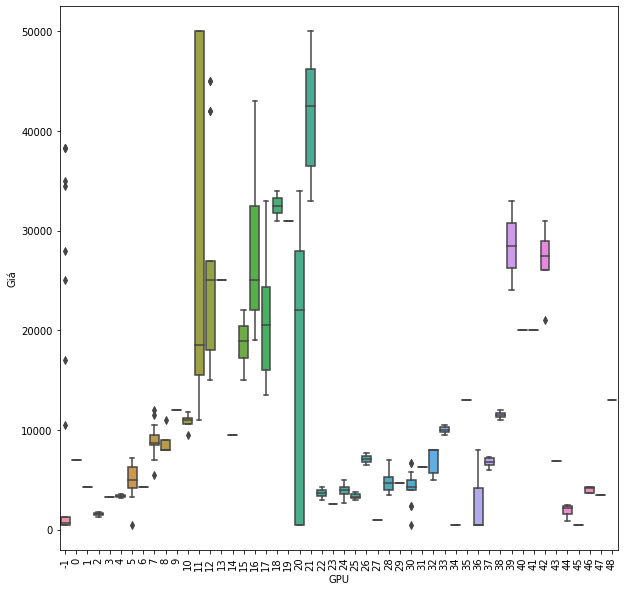

In [ ]:
Ve_BoxPlot_BienPhanLoai_vs_Gia(df_buoc3, 'GPU')

In [ ]:
df_encode, encoder, dict_data =encode(df_buoc3[['GPU']])
dict_data

{'ARM G76': 0,
 'ARM Mali-G52': 1,
 'Adreno 304': 2,
 'Adreno 505': 3,
 'Adreno 506': 4,
 'Adreno 610': 5,
 'Adreno 612': 6,
 'Adreno 618': 7,
 'Adreno 619': 8,
 'Adreno 620': 9,
 'Adreno 642L': 10,
 'Adreno 650': 11,
 'Adreno 660': 12,
 'Adreno 660l': 13,
 'Adreno™ 642L': 14,
 'Apple GPU': 15,
 'Apple GPU (4-core graphics)': 16,
 'Apple GPU 4 nhân': 17,
 'Apple GPU 5 nhân': 18,
 'Arm Mali-G78, 14 nhân': 19,
 'GPU 4 nhân': 20,
 'GPU 5 nhân': 21,
 'IMG 8322': 22,
 'IMG PowerVR GE8100': 23,
 'IMG PowerVR GE8320': 24,
 'IMG PowerVR GE8322': 25,
 'IMG PowerVR GM9446': 26,
 'Mali-400 MP2': 27,
 'Mali-G52': 28,
 'Mali-G52 2EEMC2': 29,
 'Mali-G52 MC2': 30,
 'Mali-G52 MC2aAdreno 610': 31,
 'Mali-G57 MC2': 32,
 'Mali-G57 MC3': 33,
 'Mali-G57MP4': 34,
 'Mali-G68 MC4': 35,
 'Mali-G72': 36,
 'Mali-G76 MC4': 37,
 'Mali-G77 MC9': 38,
 'Mali-G77 MP11': 39,
 'Mali-G77 MP9': 40,
 'Mali-G78 MP10': 41,
 'Mali-G78 MP14': 42,
 'Mali-T720 MP2': 43,
 'Mali-T820 MP1': 44,
 'PowerVR GE8100': 45,
 'PowerVR GE83

##Quay video

In [ ]:
KiemTraThuocTinh(df_buoc3, 'Quay video')


- Thuộc tính Quay video có tổng cộng 266 dòng.

- Số điểm dữ liệu null: 30 

- Số lượng dữ liệu độc nhất:  105
- Các dữ liệu độc nhất (unique):
['8K ở tốc độ 24fps, 4K ở tốc độ 30/60fps, 1080p ở tốc độ 30/60/240fps, 720p ở tốc độ 960fps, hỗ trợ HDR10+, chống rung OIS'
 '1080p@30fps'
 '8K@24fps, 4K@30/60fps, 1080p@30/60/240fps, 720p@960fps, HDR10+, stereo sound rec., gyro-EIS'
 '4K@30fps, 1080p@30/60fps, 720p@30fps'
 'Trước: 4K@30fps, 1080p@30fps, gyro-EIS Sau: 4K@60fps, 1080p@60/240fps (gyro-EIS), 720p@960fps (gyro-EIS), HDR10+'
 '4K @24 fps/25 fps/30 fps/ 60 fps 1080p HD @25 fps/30 fps/60 fps 720p HD@ 30 fps'
 '4K@60fps, 1080p@60/240fps (gyro-EIS), 720p@960fps (gyro-EIS), HDR10+'
 'Trước: 4K@24/30/60fps, 1080p@30/60/120fps, gyro-EIS Sau: 4K@24/30/60fps, 1080p@30/60/120/240fps, HDR, Dolby Vision HDR (up to 60fps), stereo sound rec.'
 'Quay video 4K ở tốc độ 24 fps, 30 fps hoặc 60 fps' nan
 '4K 2160p@30fps FullHD 1080p@30fps FullHD 1080p@60fps HD 720p@30fps'
 'Sau: 4K@24/30/60fps, 1080

In [ ]:
df_video_encode,encoder_video,dict_video=encode(df_buoc3[["Quay video"]])
df_video_encode

,Quay video
0,67
1,1
2,68
3,68
4,57
...,...
261,71
262,71
263,71
264,-1


Ý nghĩa của các giá trị: {'1080p@30/60/120fps': 0, '1080p@30fps': 1, '1080p@30fps; gyro-EIS': 2, '2160p@30fps, 1080p@30/60fps, 1080p@120fps, 720p@240fps': 3, '480p @30fps,720p @ 30fps, 1080p @ 30fps': 4, '480p@24fps HD 720p@24fps': 5, '480p@30fps, FullHD 1080p@30fps, HD 720p@30fps': 6, '4K 2160p@24fps, 4K 2160p@30fps, 4K 2160p@60fps, FullHD 1080p@120fps, FullHD 1080p@240fps, FullHD 1080p@30fps, FullHD 1080p@60fps': 7, '4K 2160p@24fps, 4K 2160p@30fps, 4K 2160p@60fps, FullHD 1080p@120fps, FullHD 1080p@240fps, FullHD 1080p@30fps, FullHD 1080p@60fps, HD 720p@30fps': 8, '4K 2160p@30fps FullHD 1080p@30fps': 9, '4K 2160p@30fps FullHD 1080p@30fps FullHD 1080p@60fps HD 720p@240fps': 10, '4K 2160p@30fps FullHD 1080p@30fps FullHD 1080p@60fps HD 720p@30fps': 11, '4K 2160p@30fps, 4K 2160p@60fps, 8K 4320p@24fps, FullHD 1080p@240fps, FullHD 1080p@30fps, FullHD 1080p@60fps, HD 720p@960fps': 12, '4K 2160p@30fps, 4K 2160p@60fps, 8K 4320p@30fps, FullHD 1080p@120fps, FullHD 1080p@60fps, HD 720p@120fps': 1

<Figure size 432x288 with 0 Axes>

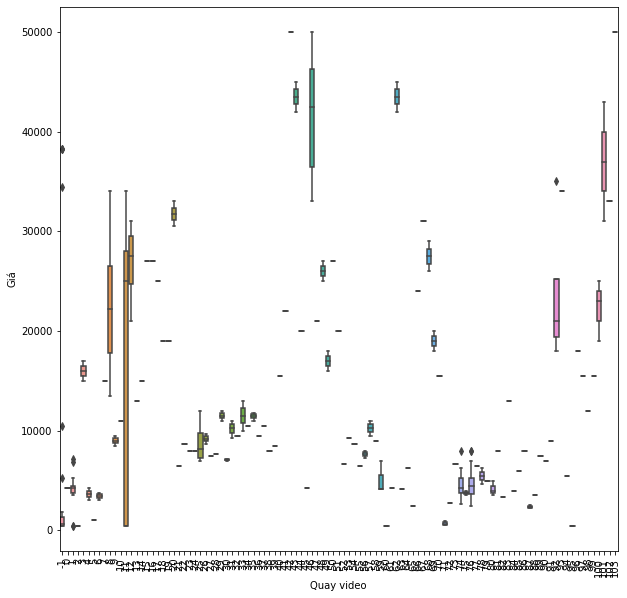

In [ ]:
Ve_BoxPlot_BienPhanLoai_vs_Gia(df_buoc3, 'Quay video')

In [ ]:
df_encode, encoder, dict_data =encode(df_buoc3[['Quay video']])
dict_data

{'1080p@30/60/120fps': 0,
 '1080p@30fps': 1,
 '1080p@30fps; gyro-EIS': 2,
 '2160p@30fps, 1080p@30/60fps, 1080p@120fps, 720p@240fps': 3,
 '480p @30fps,720p @ 30fps, 1080p @ 30fps': 4,
 '480p@24fps HD 720p@24fps': 5,
 '480p@30fps, FullHD 1080p@30fps, HD 720p@30fps': 6,
 '4K 2160p@24fps, 4K 2160p@30fps, 4K 2160p@60fps, FullHD 1080p@120fps, FullHD 1080p@240fps, FullHD 1080p@30fps, FullHD 1080p@60fps': 7,
 '4K 2160p@24fps, 4K 2160p@30fps, 4K 2160p@60fps, FullHD 1080p@120fps, FullHD 1080p@240fps, FullHD 1080p@30fps, FullHD 1080p@60fps, HD 720p@30fps': 8,
 '4K 2160p@30fps FullHD 1080p@30fps': 9,
 '4K 2160p@30fps FullHD 1080p@30fps FullHD 1080p@60fps HD 720p@240fps': 10,
 '4K 2160p@30fps FullHD 1080p@30fps FullHD 1080p@60fps HD 720p@30fps': 11,
 '4K 2160p@30fps, 4K 2160p@60fps, 8K 4320p@24fps, FullHD 1080p@240fps, FullHD 1080p@30fps, FullHD 1080p@60fps, HD 720p@960fps': 12,
 '4K 2160p@30fps, 4K 2160p@60fps, 8K 4320p@30fps, FullHD 1080p@120fps, FullHD 1080p@60fps, HD 720p@120fps': 13,
 '4K 2160

##Tính năng camera

In [ ]:
KiemTraThuocTinh(df_buoc3, 'Tính năng camera')


- Thuộc tính Tính năng camera có tổng cộng 266 dòng.

- Số điểm dữ liệu null: 96 

- Số lượng dữ liệu độc nhất:  116
- Các dữ liệu độc nhất (unique):
['AI Camera Ban đêm (Night Mode) Chuyên nghiệp (Pro) Chạm lấy nét Chống rung quang học (OIS) Chống rung điện tử kỹ thuật số (EIS) Góc rộng (Wide) Góc siêu rộng (Ultrawide) HDR Làm đẹp (Beautify)'
 'Chạm lấy nét Góc rộng (Wide) Góc siêu rộng (Ultrawide) HDR Làm đẹp Nhận diện khuôn mặt Siêu cận (Macro) Tự động lấy nét (AF) Xóa phông Zoom kỹ thuật số'
 nan
 'Audio zoom One-click AI cinema Cinematic video filters HDR video Pro Time-lapse Video pro mode Slow motion video'
 'Dual-LED dual-tone flash, HDR, panorama'
 'Chạm lấy nét HDR Nhận diện khuôn mặt Quay chậm (Slow Motion) Toàn cảnh (Panorama) Tự động lấy nét (AF) Xóa phông Nhãn dán (AR Stickers) Nhận diện khuôn mặt'
 'Quay Siêu chậm (Super Slow Motion) Lấy nét theo pha (PDAF) AI Camera Ban đêm (Night Mode) Quay chậm (Slow Motion) Xóa phông Zoom quang học Chạm lấy nét Toàn cảnh (Panorama)

In [ ]:
df_camera_encode,encoder_cam,dict_cam=encode(df_buoc3[["Tính năng camera"]])

Ý nghĩa của các giá trị: {'AI Camera Ban đêm (Night Mode) Chuyên nghiệp (Pro) Chạm lấy nét Chống rung quang học (OIS) Chống rung điện tử kỹ thuật số (EIS) Góc rộng (Wide) Góc siêu rộng (Ultrawide) HDR Làm đẹp (Beautify)': 0, 'AI Camera Ban đêm (Night Mode) Chuyên nghiệp (Pro) Chạm lấy nét Chống rung quang học (OIS) Góc rộng (Wide) Góc siêu rộng (Ultrawide) HDR Làm đẹp Nhãn dán (AR Stickers) Nhận diện khuôn mặt': 1, 'AI Camera Ban đêm (Night Mode) Quay chậm Xóa phông Zoom quang học Chạm lấy nét Toàn cảnh Chống rung quang học (OIS) Làm đẹp (Beautify) Tự động lấy nét (AF) Nhận diện khuôn mặt HDR Zoom kỹ thuật số': 2, 'AI Camera, Ban đêm (Night Mode), Chuyên nghiệp (Pro), Chạm lấy nét, Chống rung UIS, Chống rung UIS Max, Góc rộng (Wide), Góc siêu rộng (Ultrawide), HDR, Làm đẹp, Nhận diện khuôn mặt, Quay chậm (Slow Motion), Quay thiên văn, Quay video hiển thị kép, Siêu cận (Macro), Toàn cảnh (Panorama), Trôi nhanh thời gian (Time Lapse), Tự động lấy nét (AF), Xóa phông, Đơn sắc trắng đen

<Figure size 432x288 with 0 Axes>

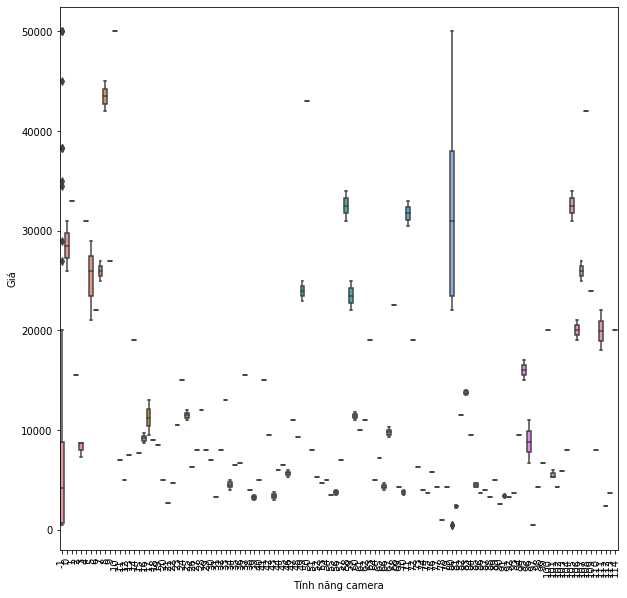

In [ ]:
Ve_BoxPlot_BienPhanLoai_vs_Gia(df_buoc3, 'Tính năng camera')

##Khe cắm thẻ nhớ

In [ ]:
KiemTraThuocTinh(df_buoc3, 'Khe cắm thẻ nhớ')


- Thuộc tính Khe cắm thẻ nhớ có tổng cộng 266 dòng.

- Số điểm dữ liệu null: 89 

- Số lượng dữ liệu độc nhất:  28
- Các dữ liệu độc nhất (unique):
['Không' 'MicroSD,  tối đa 1 TB' nan 'MicroSD,  tối đa tối đa 1TB'
 'MicroSDXC' 'MicroSD  tối đa 1TB' ' thẻ nhớ tối đa 256GB' 'MicroSD'
 'Micro SD, tối đa 256G' 'MicroSD, tối đa 128 GB' 'Micro SD  tối đa 256GB'
 'MicroSD,  tối đa 512 GB' 'Có' 'MicroSD,  tối đa 256 GB'
 'MicroSD  tối đa 256GB' 'Không ' 'Micro SD,  thẻ nhớ tối đa 256GB'
 'Up to 512 GB' 'MicroSD  tối đa 64GB' ' thẻ nhớ lên tới 256 GB'
 ' thẻ nhớ MicroSD lên tới 32GB' 'NM (Nano Memory), tối đa 256GB'
 'Micro SD' 'MicroSD,  tối đa 128 GB' 'MicroSD,  tối đa 32 GB'
 'MicroSD,  tối đa 64 GB' 'MicroSD,  tối đa 16 GB' 'MicroSD,  tối đa 8 GB']


In [ ]:
df_thenho_encode,encoder_thenho,dict_thenho=encode(df_buoc3[["Khe cắm thẻ nhớ"]])

In [ ]:
#Ve_BoxPlot_BienPhanLoai_vs_Gia(df_buoc3, 'Khe cắm thẻ nhớ')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26]),
 <a list of 27 Text major ticklabel objects>)

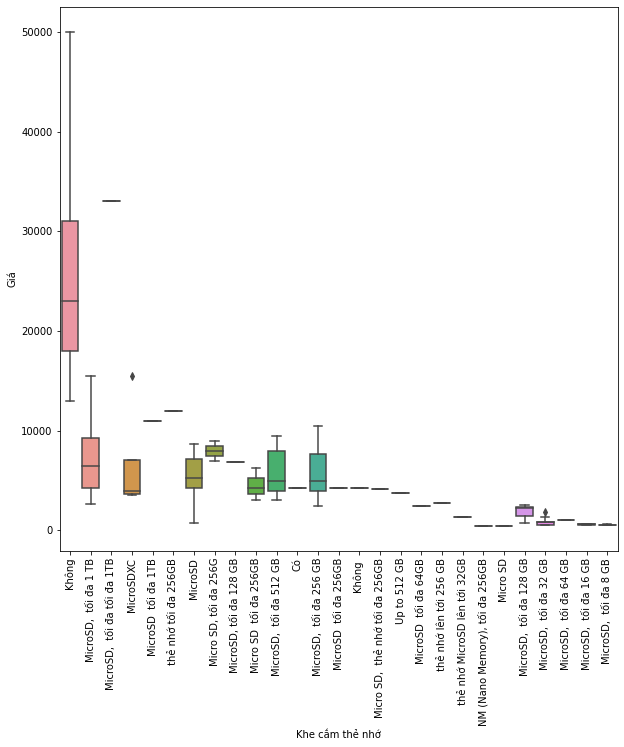

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.boxplot(x = 'Khe cắm thẻ nhớ',y = 'Giá', data = df_buoc3, ax = ax)
plt.xticks(rotation = 90)

Qua biểu đồ ta thây được những điện thoại không có khe cắm có mức giá cao hơn hẳn những điện thoại có khe cắm.

Như vậy Khe cắm thẻ nhớ có ảnh hưởng tới kết quả đầu ra.

##Công nghệ sạc

In [ ]:
KiemTraThuocTinh(df_buoc3, 'Công nghệ sạc')


- Thuộc tính Công nghệ sạc có tổng cộng 266 dòng.

- Số điểm dữ liệu null: 55 

- Số lượng dữ liệu độc nhất:  71
- Các dữ liệu độc nhất (unique):
['Sạc nhanh 25W Sạc nhanh không dây 15 Power Delivery 3.0' 'Sạc nhanh 15W'
 'Sạc nhanh 25W Sạc nhanh không dây 15W Power Delivery 3.0'
 'Công nghê sạc nhanh Xiaomi HyperCharge 67W' 'Sạc nhanh 33W' nan
 'Sạc nhanh 20W, Sạc không dây, Sạc ngược không dây 15W, Sạc pin nhanh, Tiết kiệm pin'
 'Sạc nhanh 25W Sạc nhanh không dây: 10W Sạc ngược không dây: 4.5W'
 'Sạc nhanh 20W Sạc không dây 15W Power Delivery 2.0'
 'Sạc nhanh 20W Sạc nhanh không dây 15W Power Delivery 2.0'
 'Sạc không dây, hỗ trợ sạc nhanh 15W' 'Sạc nhanh 15W, Sạc không dây 10W'
 'Sạc nhanh 65W Sạc nhanh không dây 30W Sạc ngược 10W'
 'Sạc nhanh 20W Power Delivery 2.0'
 'Sạc nhanh 25W Sạc nhanh không dây 25W Power Delivery 3.0'
 'Sạc nhanh 18W Power Delivery 2.0'
 'Sạc nhanh 30W, hỗ trợ sạc nhanh tối đa 120W'
 'Sạc nhanh 30W, Power Delivery 3.0, Quick Charge 4' 'Sạc nhanh 44W'
 'Sạc 

In [ ]:
df_sac_encode,encoder,dict_sac=encode(df_buoc3[["Công nghệ sạc"]])

Ý nghĩa của các giá trị: {'Công nghê sạc nhanh Xiaomi HyperCharge 67W': 0, 'Hỗ trợ sạc tối đa 10 W': 1, 'Hỗ trợ sạc tối đa 10W': 2, 'Siêu tiết kiệm pin Sạc pin nhanh': 3, 'Siêu tiết kiệm pin Tiết kiệm pin': 4, 'Siêu tiết kiệm pin, Sạc không dây, Sạc không dây MagSafe, Sạc pin nhanh': 5, 'Siêu tiết kiệm pin, Sạc không dây, Sạc ngược không dây, Sạc pin nhanh, Tiết kiệm pin': 6, 'Siêu tiết kiệm pin, Sạc ngược qua cáp, Sạc pin nhanh': 7, 'Siêu tiết kiệm pin, Sạc pin nhanh, Tiết kiệm pin': 8, 'Sạc 15W': 9, 'Sạc không dây Sạc pin nhanh': 10, 'Sạc không dây, Sạc không dây MagSafe, Sạc pin nhanh, Tiết kiệm pin': 11, 'Sạc không dây, Sạc ngược không dây, Sạc pin nhanh, Tiết kiệm pin': 12, 'Sạc không dây, Sạc pin nhanh, Tiết kiệm pin': 13, 'Sạc không dây, Sạc siêu nhanh SuperVOOC, Tiết kiệm pin': 14, 'Sạc không dây, Tiết kiệm pin, Sạc không dây MagSafe, Sạc pin nhanh': 15, 'Sạc không dây, hỗ trợ sạc nhanh 15W': 16, 'Sạc ngược qua cáp': 17, 'Sạc ngược qua cáp Sạc pin nhanh': 18, 'Sạc ngược qua cáp

<Figure size 432x288 with 0 Axes>

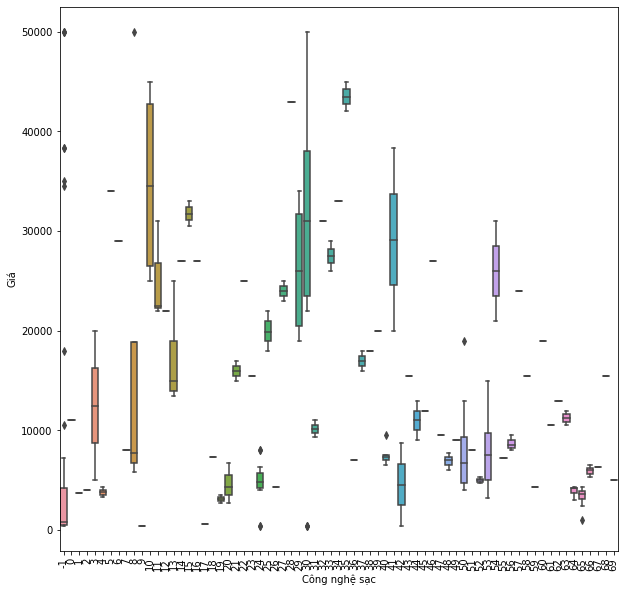

In [ ]:
Ve_BoxPlot_BienPhanLoai_vs_Gia(df_buoc3, 'Công nghệ sạc')

##Cổng sạc

In [ ]:
KiemTraThuocTinh(df_buoc3, 'Cổng sạc')


- Thuộc tính Cổng sạc có tổng cộng 266 dòng.

- Số điểm dữ liệu null: 30 

- Số lượng dữ liệu độc nhất:  7
- Các dữ liệu độc nhất (unique):
['USB Type-C' nan 'Lightning' 'Micro-USB' 'Type-C' 'Micro USB'
 '2 đầu Type-C']


In [ ]:
df_congsac_encode,encoder,dict_congsac=encode(df_buoc3[["Cổng sạc"]])

In [ ]:
data_congsac=df_buoc3["Cổng sạc"].value_counts(dropna=False)

labels_congsac = [f'{l}, {s*100/(data_congsac.sum()):0.1f}%' for l, s in zip(data_congsac.index, data_congsac)]

In [ ]:
data_congsac

Type-C          86
USB Type-C      56
Micro USB       41
Lightning       39
NaN             30
Micro-USB       13
2 đầu Type-C     1
Name: Cổng sạc, dtype: int64

<Figure size 432x288 with 0 Axes>

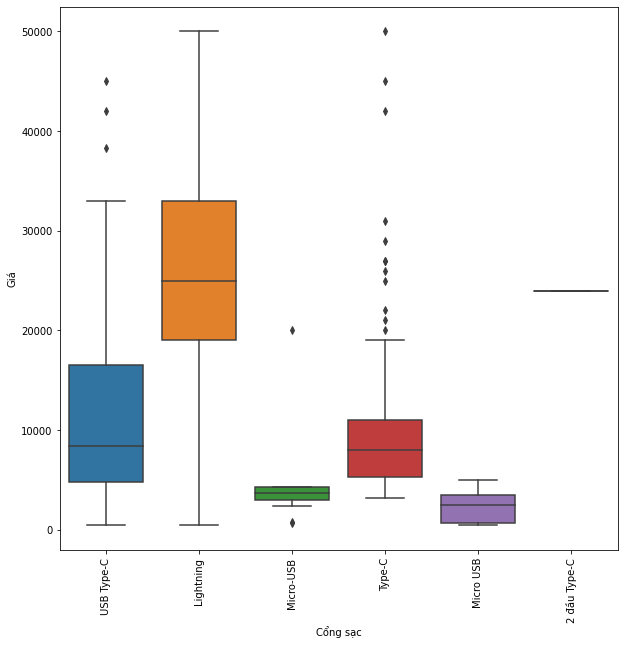

In [ ]:
Ve_BoxPlot_BienPhanLoai_vs_Gia(df_buoc3, 'Cổng sạc')

Ta thấy biểu đồ có sự phân loại giá khó rõ ràng với cổng sạc Lightning có mức giá cao hơn hẳn so với các cổng sạc còn lại, tiếp đến là cổng USB Type-C và cuối dùng là cổng Micro-USB.

Do đó có thể nói rằng Cổng sạc có ảnh hưởng đến giá tiền.

##Wifi

In [ ]:
KiemTraThuocTinh(df_buoc3, 'Wi-Fi')


- Thuộc tính Wi-Fi có tổng cộng 266 dòng.

- Số điểm dữ liệu null: 30 

- Số lượng dữ liệu độc nhất:  53
- Các dữ liệu độc nhất (unique):
['Wi-Fi 802.11 a/b/g/n/ac/6e, dual-band, Wi-Fi Direct, hotspot'
 'Wi-Fi 802.11 b/g/n, Wi-Fi Direct, hotspot'
 'Wi-Fi 802.11 a/b/g/n/ac/6, dual-band, Wi-Fi Direct, hotspot' 'Wi-Fi 6'
 'Dual-band (2.4 GHz/5 GHz) Wi-Fi 802.11 a/b/g/n/ac/ax Wi-Fi MIMO Wi-Fi hotspot'
 'Wi-Fi 802.11 a/b/g/n/ac/ax, HE80, MIMO, 1024-QAM' 'WiFi 6E'
 'Wi-Fi 802.11 a/b/g/n/ac/6, dual-band, hotspot'
 '802.11ax Wi‑Fi 6 with 2x2 MIMO' '802.11ax 2x2' 'Wi‑Fi 6 (802.11ax)'
 'Wi-Fi 802.11 a/b/g/n/ac/6, băng tần kép, Wi-Fi Direct, hotspot'
 'Wi-Fi 802.11 a/b/g/n/ac, dual-band, Wi-Fi Direct, hotspot'
 '802.11 a/b/g/n/ac, 2 ăng-ten, điểm truy cập cá nhân'
 'Wi-Fi hotspot, Dual-band (2.4 GHz/5 GHz), Wi-Fi Direct, Wi-Fi 802.11 a/b/g/n/ac'
 'Wifi 6, 2.4G/5G, 802.11 a/b/g/n/ac/ax' nan '2.4G/5G, 802.11 a/b/g/n/ac'
 '2.4GHz 5GHz, 802.11b/g/n'
 'Wi-Fi 802.11 a/b/g/n, dual-band, WiFi Direct, ho

In [ ]:
df_wifi_encode,encoder,dict_wifi=encode(df_buoc3[["Wi-Fi"]])

Ý nghĩa của các giá trị: {'2.4G/5G, 802.11 a/b/g/n/ac': 0, '2.4GHz 5GHz, 802.11b/g/n': 1, '802.11 a/b/g/n/ac, 2 ăng-ten, điểm truy cập cá nhân': 2, '802.11 a/b/g/n/ac, dual-band, Wi-Fi Direct, hotspot': 3, '802.11ax 2x2': 4, '802.11ax Wi‑Fi 6 with 2x2 MIMO': 5, 'Có': 6, 'Dual-band (2.4 GHz/5 GHz) Wi-Fi 802.11 a/b/g/n/ac': 7, 'Dual-band (2.4 GHz/5 GHz) Wi-Fi 802.11 a/b/g/n/ac/ax Wi-Fi MIMO Wi-Fi hotspot': 8, 'Dual-band (2.4 GHz/5 GHz), Wi-Fi 802.11 a/b/g/n/ac, Wi-Fi Direct , Wi-Fi hotspot': 9, 'Dual-band (2.4 GHz/5 GHz), Wi-Fi 802.11 a/b/g/n/ac, Wi-Fi Direct, Wi-Fi hotspot': 10, 'Dual-band (2.4 GHz/5 GHz), Wi-Fi 802.11 a/b/g/n/ac, Wi-Fi hotspot': 11, 'Dual-band (2.4 GHz/5 GHz), Wi-Fi 802.11 a/b/g/n/ac/ax, Wi-Fi Direct, Wi-Fi hotspot': 12, 'Dual-band (2.4 GHz/5 GHz), Wi-Fi 802.11 a/b/g/n/ac/ax, Wi-Fi Direct, Wi-Fi hotspot, Wi-Fi MIMO': 13, 'Dual-band (2.4 GHz/5 GHz), Wi-Fi 802.11 a/b/g/n/ac/ax, Wi-Fi hotspot': 14, 'Dual-band (2.4 GHz/5 GHz), Wi-Fi 802.11 a/b/g/n/ac/ax, Wi-Fi hotspot, Wi-

<Figure size 432x288 with 0 Axes>

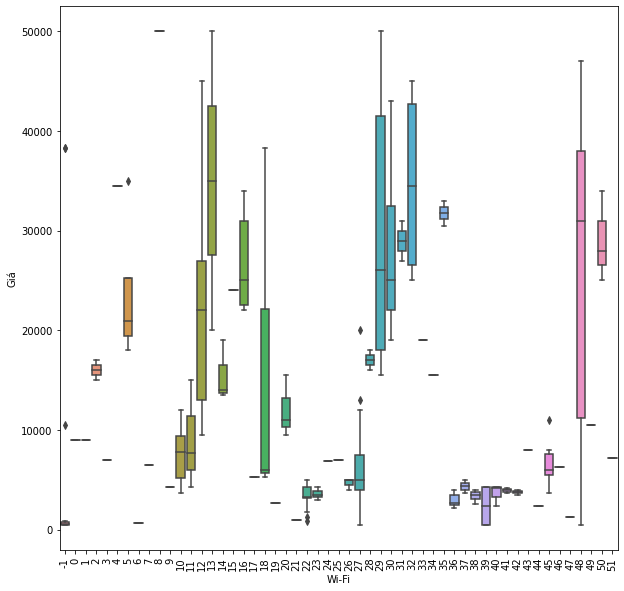

In [ ]:
Ve_BoxPlot_BienPhanLoai_vs_Gia(df_buoc3, 'Wi-Fi')

##Bluetooth

In [ ]:
KiemTraThuocTinh(df_buoc3, 'Bluetooth')


- Thuộc tính Bluetooth có tổng cộng 266 dòng.

- Số điểm dữ liệu null: 19 

- Số lượng dữ liệu độc nhất:  45
- Các dữ liệu độc nhất (unique):
['5.1, A2DP, LE5.2, A2DP, LE' '5.0, A2DP, LE' 'Bluetooth 5.2' '5.1'
 '5.0, A2DP, LE, aptX HD' '5.0' '5.2, A2DP, LE, aptX HD'
 '5.0, A2DP, LE, aptX' '5.1, A2DP, LE, aptX HD, aptX Adaptive'
 '5.1, A2DP, aptX, LE' '5.2, A2DP, aptX, LE' '5.2'
 '5.2, A2DP, LE, aptX HD, aptX Adaptive' '5.1, A2DP, LE, aptX HD'
 '5.1, A2DP, LE' '4.1, A2DP, EDR, LE' nan 'LE 5.1 A2DP' 'A2DP, LE, 5.1'
 '4.2, A2DP, aptX Adaptive' '4.2, A2DP' '4.0, A2DP' '3.0'
 'Yes 5.0, A2DP, LE' 'A2DPLE' 'A2DP 5.0' 'A2DP, LE, 5.0' 'LE, A2DP, 5.1'
 'A2DP, apt-X, LE, 5.0' 'A2DP, apt-X, 5.0' 'A2DP, LE, apt-X, 5.1'
 '5.0 A2DP' 'A2DP LE' 'LE, A2DP, 5.0' '5.1, LE, A2DP' '5.0, LE, A2DP'
 'A2DP, 5.0, LE' 'A2DP, EDR, LE, 5.0' 'LE 5.0' 'A2DP, LE, 4.2' '4.2'
 'A2DP 4.2' 'v4.3' 'Có' 'v4.0']


In [ ]:
df_bluetooth_encode,encoder,dict_bluetooth=encode(df_buoc3[["Bluetooth"]])

Ý nghĩa của các giá trị: {'3.0': 0, '4.0, A2DP': 1, '4.1, A2DP, EDR, LE': 2, '4.2': 3, '4.2, A2DP': 4, '4.2, A2DP, aptX Adaptive': 5, '5.0': 6, '5.0 A2DP': 7, '5.0, A2DP, LE': 8, '5.0, A2DP, LE, aptX': 9, '5.0, A2DP, LE, aptX HD': 10, '5.0, LE, A2DP': 11, '5.1': 12, '5.1, A2DP, LE': 13, '5.1, A2DP, LE, aptX HD': 14, '5.1, A2DP, LE, aptX HD, aptX Adaptive': 15, '5.1, A2DP, LE5.2, A2DP, LE': 16, '5.1, A2DP, aptX, LE': 17, '5.1, LE, A2DP': 18, '5.2': 19, '5.2, A2DP, LE, aptX HD': 20, '5.2, A2DP, LE, aptX HD, aptX Adaptive': 21, '5.2, A2DP, aptX, LE': 22, 'A2DP 4.2': 23, 'A2DP 5.0': 24, 'A2DP LE': 25, 'A2DP, 5.0, LE': 26, 'A2DP, EDR, LE, 5.0': 27, 'A2DP, LE, 4.2': 28, 'A2DP, LE, 5.0': 29, 'A2DP, LE, 5.1': 30, 'A2DP, LE, apt-X, 5.1': 31, 'A2DP, apt-X, 5.0': 32, 'A2DP, apt-X, LE, 5.0': 33, 'A2DPLE': 34, 'Bluetooth 5.2': 35, 'Có': 36, 'LE 5.0': 37, 'LE 5.1 A2DP': 38, 'LE, A2DP, 5.0': 39, 'LE, A2DP, 5.1': 40, 'Yes 5.0, A2DP, LE': 41, 'v4.0': 42, 'v4.3': 43, nan: -1}


<Figure size 432x288 with 0 Axes>

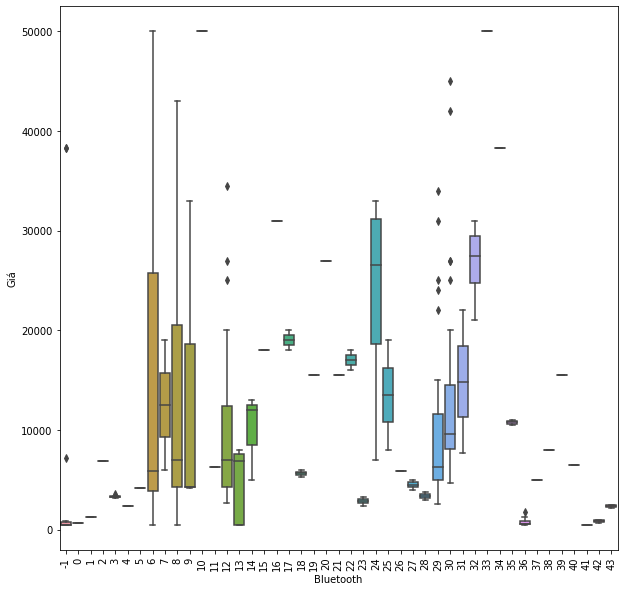

In [ ]:
Ve_BoxPlot_BienPhanLoai_vs_Gia(df_buoc3, 'Bluetooth')

##GPS

In [ ]:
KiemTraThuocTinh(df_buoc3, 'GPS')


- Thuộc tính GPS có tổng cộng 266 dòng.

- Số điểm dữ liệu null: 33 

- Số lượng dữ liệu độc nhất:  50
- Các dữ liệu độc nhất (unique):
['Có, hỗ trợ A-GPS, GLONASS, BDS, GALILEO' 'A-GPS, GLONASS, GALILEO, BDS'
 'A-GPS, GLONASS, BDS, GALILEO, QZSS' 'A-GPS, GLONASS, BDS, GALILEO'
 'GPS, GLONASS, Galileo, QZSS, and BeiDou' 'A-GPS, GLONASS, GALILEO, QZSS'
 'GPS/GNSS' nan 'Có, hỗ trợ 2 băng tần A-GPS, GLONASS, BDS, GALILEO, QZSS'
 'dual-band A-GPS, GLONASS, BDS, GALILEO, QZSS, GNSS'
 'Có, hỗ trợ băng tần kép A-GPS, GLONASS, GALILEO, BDS, QZSS'
 'A-GPS, GLONASS, BDS'
 'Băng tầm kép A-GPS, GLONASS, GALILEO, BDS, QZSS, NavIC' 'A-GPS, GLONASS'
 'GPS, Glonass, Beidou, Galileo, QZSS'
 'Yes, with dual-band A-GPS, GLONASS, BDS, GALILEO, QZSS'
 'Có, hỗ trợ A-GPS, GLONASS, BDS' 'A-GPS, GLONASS, GALILEO, BDS, NavIC'
 'A-GPS' 'Có, hỗ trợ A-GPS, GLONASS, GALILEO, BDS' 'A-GPS, GLONASS/ BDS'
 'Có, hỗ trợ A-GPS, GLONASS' 'Đang cập nhật' 'A-GPS GALILEO GLONASS BDS'
 'Có, hỗ trợ A-GPS, GLONASS, GALILEO, BDS

In [ ]:
df_gps_encode,encoder,dict_gps=encode(df_buoc3[["GPS"]])

Ý nghĩa của các giá trị: {'A-GPS': 0, 'A-GPS BDS': 1, 'A-GPS GALILEO GLONASS BDS': 2, 'A-GPS GLONASS': 3, 'A-GPS,': 4, 'A-GPS, BDS, GALILE, GLONASS': 5, 'A-GPS, BDS, GALILEO': 6, 'A-GPS, BDS, GALILEO, GLONASS': 7, 'A-GPS, BDS, GALILEO, GLONASS, QZSS': 8, 'A-GPS, BDS, GALILEO, GLONASS, iBeacon, QZSS': 9, 'A-GPS, BDS, GLONASS': 10, 'A-GPS, GALILEO, BDS, GLONASS': 11, 'A-GPS, GLONASS': 12, 'A-GPS, GLONASS, BDS': 13, 'A-GPS, GLONASS, BDS, GALILEO': 14, 'A-GPS, GLONASS, BDS, GALILEO, QZSS': 15, 'A-GPS, GLONASS, GALILEO, BDS': 16, 'A-GPS, GLONASS, GALILEO, BDS, NavIC': 17, 'A-GPS, GLONASS, GALILEO, QZSS': 18, 'A-GPS, GLONASS/ BDS': 19, 'A-GPSBDS': 20, 'BDS, A-GPS, GLONASS': 21, 'BDS, GALILEO, GLONASS': 22, 'BDS, GLONASS, A-GPS': 23, 'Băng tầm kép A-GPS, GLONASS, GALILEO, BDS, QZSS, NavIC': 24, 'Có': 25, 'Có, hỗ trợ 2 băng tần A-GPS, GLONASS, BDS, GALILEO, QZSS': 26, 'Có, hỗ trợ A-GPS, GLONASS': 27, 'Có, hỗ trợ A-GPS, GLONASS, BDS': 28, 'Có, hỗ trợ A-GPS, GLONASS, BDS, GALILEO': 29, 'Có, hỗ t

<Figure size 432x288 with 0 Axes>

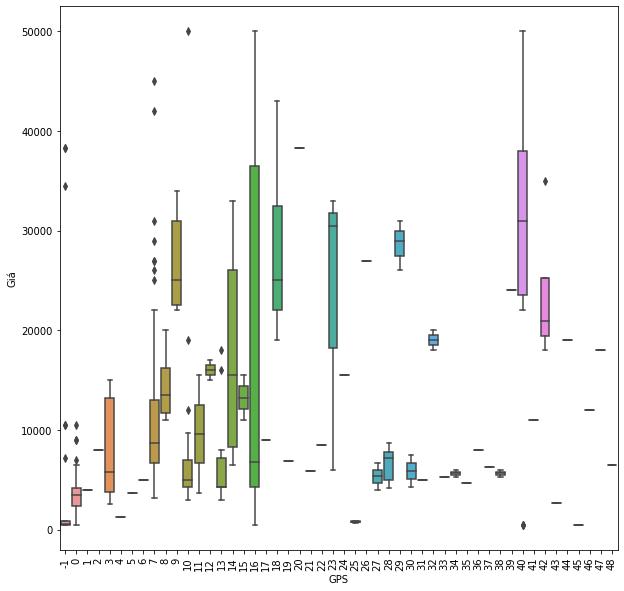

In [ ]:
Ve_BoxPlot_BienPhanLoai_vs_Gia(df_buoc3, 'GPS')

In [ ]:
df_encode, encoder, dict_data =encode(df_buoc3[['GPS']])
dict_data

{'A-GPS': 0,
 'A-GPS BDS': 1,
 'A-GPS GALILEO GLONASS BDS': 2,
 'A-GPS GLONASS': 3,
 'A-GPS,': 4,
 'A-GPS, BDS, GALILE, GLONASS': 5,
 'A-GPS, BDS, GALILEO': 6,
 'A-GPS, BDS, GALILEO, GLONASS': 7,
 'A-GPS, BDS, GALILEO, GLONASS, QZSS': 8,
 'A-GPS, BDS, GALILEO, GLONASS, iBeacon, QZSS': 9,
 'A-GPS, BDS, GLONASS': 10,
 'A-GPS, GALILEO, BDS, GLONASS': 11,
 'A-GPS, GLONASS': 12,
 'A-GPS, GLONASS, BDS': 13,
 'A-GPS, GLONASS, BDS, GALILEO': 14,
 'A-GPS, GLONASS, BDS, GALILEO, QZSS': 15,
 'A-GPS, GLONASS, GALILEO, BDS': 16,
 'A-GPS, GLONASS, GALILEO, BDS, NavIC': 17,
 'A-GPS, GLONASS, GALILEO, QZSS': 18,
 'A-GPS, GLONASS/ BDS': 19,
 'A-GPSBDS': 20,
 'BDS, A-GPS, GLONASS': 21,
 'BDS, GALILEO, GLONASS': 22,
 'BDS, GLONASS, A-GPS': 23,
 'Băng tầm kép A-GPS, GLONASS, GALILEO, BDS, QZSS, NavIC': 24,
 'Có': 25,
 'Có, hỗ trợ 2 băng tần A-GPS, GLONASS, BDS, GALILEO, QZSS': 26,
 'Có, hỗ trợ A-GPS, GLONASS': 27,
 'Có, hỗ trợ A-GPS, GLONASS, BDS': 28,
 'Có, hỗ trợ A-GPS, GLONASS, BDS, GALILEO': 29,
 'Có,

##Trọng lượng

In [ ]:
KiemTraThuocTinh(df_buoc3, 'Trọng lượng')


- Thuộc tính Trọng lượng có tổng cộng 266 dòng.

- Số điểm dữ liệu null: 126 

- Số lượng dữ liệu độc nhất:  70
- Các dữ liệu độc nhất (unique):
[   nan 271.   164.   203.   196.   173.   189.   175.   194.   178.8
 182.   188.   240.   204.   282.   228.   183.   174.   193.   141.
 201.   184.   135.   192.   170.   190.   218.   148.   180.   161.
 171.   213.   177.   158.   176.   157.   172.   185.   202.   196.5
 191.   186.   198.   200.   209.   192.3  199.   181.   205.   179.
 237.   206.   178.   110.2  104.7  169.    95.    84.5   97.3   90.3
  80.2   90.54 110.   166.   130.   123.6   80.   176.1  235.   112.  ]


In [ ]:
#drop outlier
df_buoc3.drop(df_buoc3[df_buoc3["Trọng lượng"] == 2400].index,inplace=True)

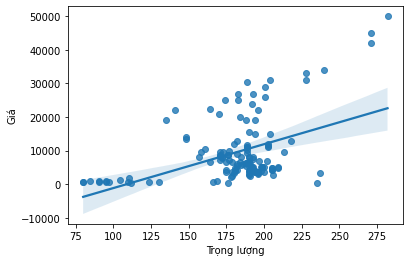

In [ ]:
sns.regplot(x="Trọng lượng",y="Giá",data=df_buoc3)

##Chất liệu mặt lưng

In [ ]:
KiemTraThuocTinh(df_buoc3, 'Chất liệu mặt lưng')


- Thuộc tính Chất liệu mặt lưng có tổng cộng 266 dòng.

- Số điểm dữ liệu null: 43 

- Số lượng dữ liệu độc nhất:  12
- Các dữ liệu độc nhất (unique):
['Kính' 'Nhựa' nan 'Kim loại' 'kính cường lực' 'kính' 'nhựa'
 'thuỷ tinh hữu cơ' 'nhựa Polycarbonate' 'kính cường lực Gorilla Glass 5'
 'kính Panda' 'nhựa Polymer cao cấp']


In [ ]:
df_matlung_encode,encoder,dict_matlung=encode(df_buoc3[["Chất liệu mặt lưng"]])

In [ ]:
data_matlung=df_buoc3["Chất liệu mặt lưng"].value_counts(dropna=False)

labels_matlung = [f'{l}, {s*100/(data_matlung.sum()):0.1f}%' for l, s in zip(data_matlung.index, data_matlung)]

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 <a list of 11 Text major ticklabel objects>)

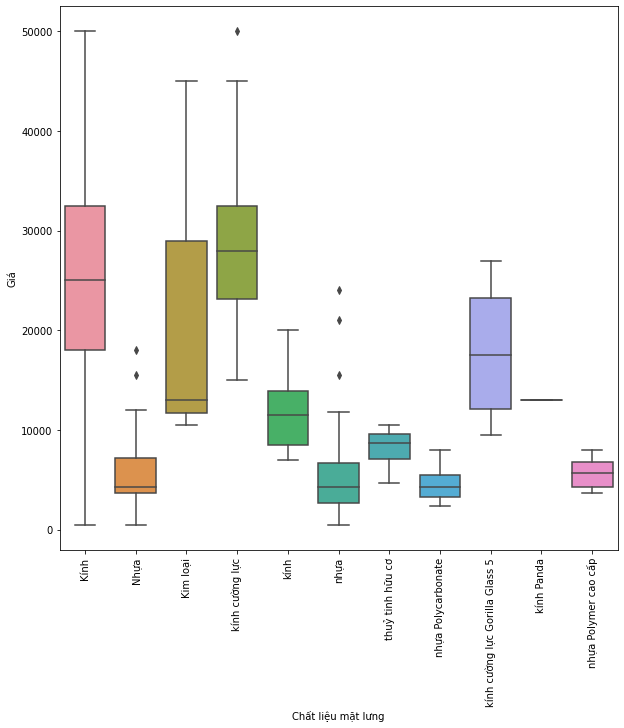

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.boxplot(x = 'Chất liệu mặt lưng',y = 'Giá', data = df_buoc3, ax = ax)
plt.xticks(rotation = 90)

Qua biểu đồ ta thấy có sự phân biệt rõ ràng giữa các biến phân loại, cụ thể những điện thoại mặt Kính có mức giá cao hơn so với mặt nhựa.

Như vậy có thể suy ra rằng Chất liệu mặt lưng có ảnh hưởng đến giá tiền.

## Chất liệu khung viền 

In [ ]:
KiemTraThuocTinh(df_buoc3, 'Chất liệu khung viền')


- Thuộc tính Chất liệu khung viền có tổng cộng 266 dòng.

- Số điểm dữ liệu null: 161 

- Số lượng dữ liệu độc nhất:  12
- Các dữ liệu độc nhất (unique):
['Kim loại' nan 'Nhựa' 'Kính' 'nhôm ' 'kim loại ' 'hợp kim '
 'hợp kim nhôm ' 'thép không gỉ ' 'hợp kim phủ nhựa '
 'nhựa phủ sơn kim loại ' 'nhựa ']


In [ ]:
df_CLKV_encode, encoder_CLKV, dict_CLKV = encode(df_buoc3[['Chất liệu khung viền']])

In [ ]:
CLKV_fre = [df_CLKV_encode.value_counts().loc[i].values[0] / len(df_CLKV_encode) for i in list(dict_CLKV.values())]
print(CLKV_fre)

[0.15789473684210525, 0.007518796992481203, 0.015037593984962405, 0.007518796992481203, 0.011278195488721804, 0.007518796992481203, 0.07894736842105263, 0.06015037593984962, 0.02631578947368421, 0.007518796992481203, 0.015037593984962405, 0.6052631578947368]


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 <a list of 11 Text major ticklabel objects>)

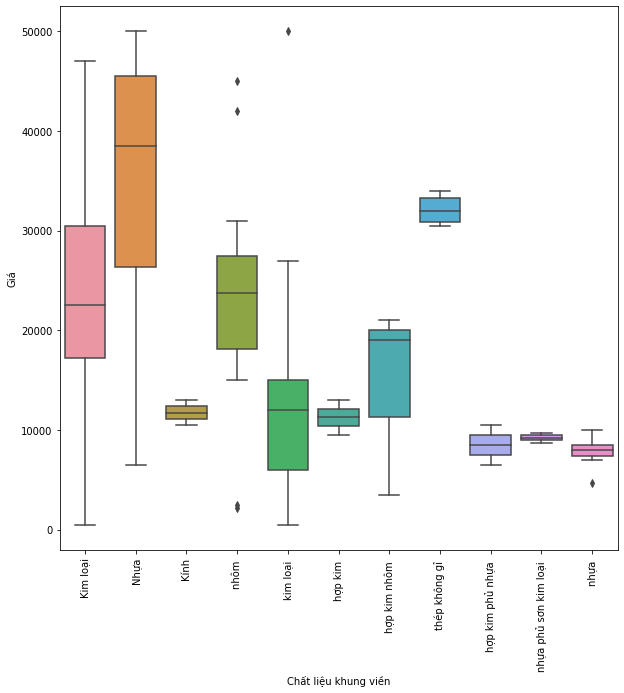

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.boxplot(x = 'Chất liệu khung viền',y = 'Giá', data = df_buoc3, ax = ax)
plt.xticks(rotation = 90)

Qua biểu đồ ta nhận thấy giữa các chất liệu không có sự phân biệt rõ ràng như nhựa và kim loại với đa dạng về giá.

Như vậy có thể kết luận rằng Chất liệu khung viền ít ảnh hưởng tới giá tiền.

## Chỉ số kháng nước, bụi

In [ ]:
KiemTraThuocTinh(df_buoc3, 'Chỉ số kháng nước, bụi')



- Thuộc tính Chỉ số kháng nước, bụi có tổng cộng 266 dòng.

- Số điểm dữ liệu null: 187 

- Số lượng dữ liệu độc nhất:  8
- Các dữ liệu độc nhất (unique):
['Ip68' nan 'IPX8' 'IP67' 'Không có' 'IP53' 'IPX4' 'IP54']


In [ ]:
# Thay thế giá trị 'Không có' -> np.nan. 
# Vì nếu cùng có cả hai giá trị này trong column thì rất vô nghĩa.
df_buoc3['Chỉ số kháng nước, bụi'] = df_buoc3['Chỉ số kháng nước, bụi'].replace('Không có', np.nan)
KiemTraThuocTinh(df_buoc3, 'Chỉ số kháng nước, bụi')


- Thuộc tính Chỉ số kháng nước, bụi có tổng cộng 266 dòng.

- Số điểm dữ liệu null: 205 

- Số lượng dữ liệu độc nhất:  7
- Các dữ liệu độc nhất (unique):
['Ip68' nan 'IPX8' 'IP67' 'IP53' 'IPX4' 'IP54']


In [ ]:
df_khangNuoc_encode, encoder_khangNuoc, dict_khangNuoc = encode(df_buoc3[["Chỉ số kháng nước, bụi"]])
print('Chuyển đổi tương ứng giữa thuộc tính text cũ và numeric mới:\n', dict_khangNuoc)

Chuyển đổi tương ứng giữa thuộc tính text cũ và numeric mới:
 {'IP53': 0, 'IP54': 1, 'IP67': 2, 'IPX4': 3, 'IPX8': 4, 'Ip68': 5, nan: -1}


(array([0, 1, 2, 3, 4, 5]), <a list of 6 Text major ticklabel objects>)

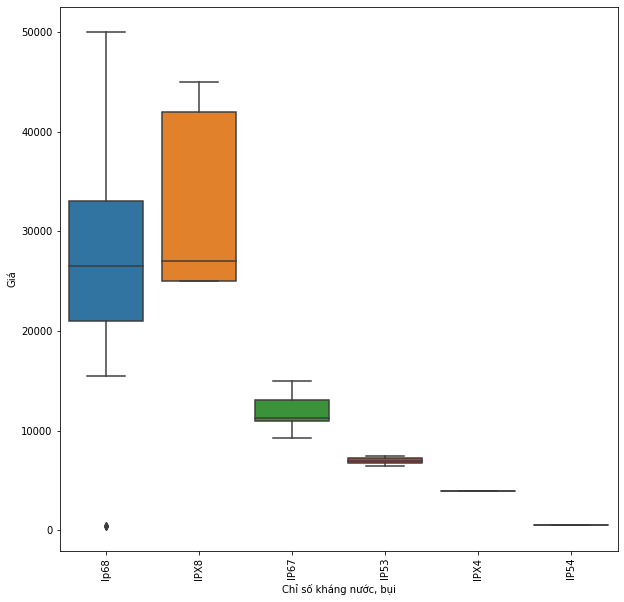

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.boxplot(x = 'Chỉ số kháng nước, bụi',y = 'Giá', data = df_buoc3, ax = ax)
plt.xticks(rotation = 90)

Qua biểu đồ trên ta nhận thấy rằng những điện thoại có chỉ số như IP68, IPX8 có mức giá khá cao, tách biệt so với những chỉ số khác như IP53, IPX4 hay không có.

Như vậy có thể thấy rằng Chỉ số kháng nước, bụi có ảnh hưởng đến giá tiền.

## 'Cảm biến vân tay'

In [ ]:
KiemTraThuocTinh(df_buoc3, 'Cảm biến')


- Thuộc tính Cảm biến có tổng cộng 266 dòng.

- Số điểm dữ liệu null: 84 

- Số lượng dữ liệu độc nhất:  12
- Các dữ liệu độc nhất (unique):
['Cảm biến vân tay trong màn hình' 'Mở khoá vân tay cạnh viền' nan
 'Cảm biến vân tay mặt lưng' 'Mở khoá khuôn mặt'
 'Mở khoá khuôn mặt Mở khoá vân tay cạnh viền'
 'Mở khoá khuôn mặt Mở khoá vân tay dưới màn hình'
 'Mở khoá khuôn mặt Mở khóa bằng vân tay' 'Mở khoá vân tay dưới màn hình'
 'Mở khóa bằng vân tay' 'Mở khoá vân tay dưới màn hình Mở khoá khuôn mặt'
 'Mở khoá vân tay cạnh viền Mở khoá khuôn mặt']


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 <a list of 11 Text major ticklabel objects>)

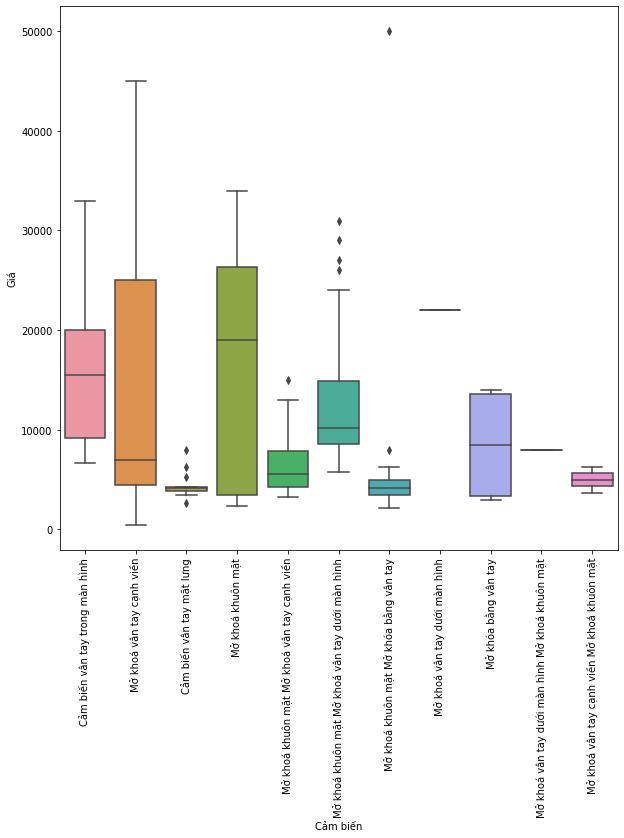

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.boxplot(x = 'Cảm biến',y = 'Giá', data = df_buoc3, ax = ax)
plt.xticks(rotation = 90)

Qua biểu đồ trên ta nhận thấy rằng giữa các vị trí mở khóa không có sự chênh lệch quá rõ ràng. Như vậy có thể đưa ra kết luận rằng Cảm biến không ảnh hưởng nhiều đến giá tiền.

## Tính năng đặc biệt

In [ ]:
KiemTraThuocTinh(df_buoc3, 'Tính năng đặc biệt')


- Thuộc tính Tính năng đặc biệt có tổng cộng 266 dòng.

- Số điểm dữ liệu null: 73 

- Số lượng dữ liệu độc nhất:  78
- Các dữ liệu độc nhất (unique):
['Hỗ trợ 5G, Kháng nước, kháng bụi, Sạc không dây, Nhận diện khuôn mặt, Bảo mật vân tay'
 nan 'Hỗ trợ 5G, Kháng nước, kháng bụi, Sạc không dây, Bảo mật vân tay'
 'Hỗ trợ 5G, Sạc không dây, Bảo mật vân tay'
 'Hỗ trợ 5G, Kháng nước, kháng bụi, Sạc không dây, Nhận diện khuôn mặt'
 'Kháng nước, kháng bụi, Nhận diện khuôn mặt'
 'Ổ cứng SSD, Wi-Fi 6, Viền màn hình siêu mỏng' 'Sạc không dây'
 'Kháng nước, kháng bụi, Sạc không dây, Nhận diện khuôn mặt'
 'Hỗ trợ 5G, Bảo mật vân tay' 'Hỗ trợ 5G'
 'Kháng nước, kháng bụi, Sạc không dây, Nhận diện khuôn mặt, Bảo mật vân tay'
 'Hỗ trợ 5G, Kháng nước, kháng bụi, Nhận diện khuôn mặt, Bảo mật vân tay'
 'Bảo mật vân tay' 'Hỗ trợ 5G, Nhận diện khuôn mặt, Bảo mật vân tay'
 'Kháng nước, kháng bụi, Bảo mật vân tay'
 'Nhận diện khuôn mặt, Bảo mật vân tay'
 'Kháng nước, kháng bụi, Nhận diện khuôn mặt, Bảo mật 

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76]),
 <a list of 77 Text major ticklabel objects>)

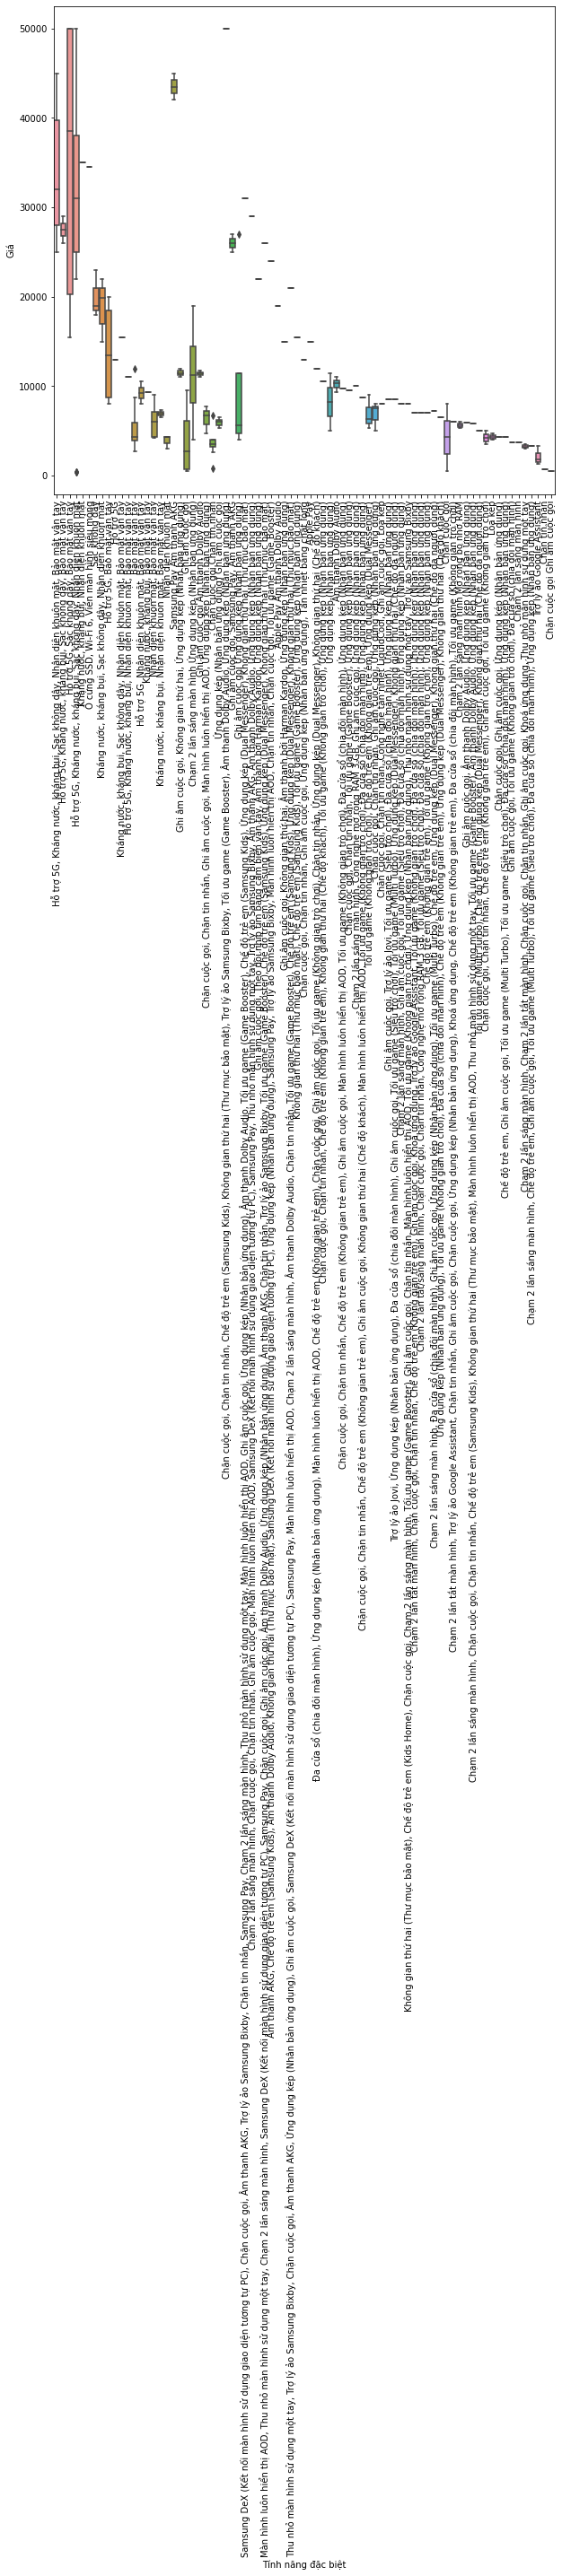

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.boxplot(x = 'Tính năng đặc biệt',y = 'Giá', data = df_buoc3, ax = ax)
plt.xticks(rotation = 90)


## 'Jack tai nghe 3.5'

In [ ]:
var = 'Jack tai nghe 3.5'

In [ ]:
KiemTraThuocTinh(df_buoc3, var)


- Thuộc tính Jack tai nghe 3.5 có tổng cộng 266 dòng.

- Số điểm dữ liệu null: 71 

- Số lượng dữ liệu độc nhất:  6
- Các dữ liệu độc nhất (unique):
[nan 'Có' 'Không' 'Lightning' 'Type-C' 'Micro USB']


In [ ]:
# Thay thế giá trị np.nan -> 'Không'
# Vì nếu cùng có cả hai giá trị này trong column thì rất vô nghĩa.
df_buoc3[var] = df_buoc3[var].replace(np.nan, 'Không')
# tương tự đối với giá trị '3.5 mm' -> 'Có'
df_buoc3[var] = df_buoc3[var].replace('3.5 mm', 'Có')
KiemTraThuocTinh(df_buoc3, var)


- Thuộc tính Jack tai nghe 3.5 có tổng cộng 266 dòng.

- Số điểm dữ liệu null: 0 

- Số lượng dữ liệu độc nhất:  5
- Các dữ liệu độc nhất (unique):
['Không' 'Có' 'Lightning' 'Type-C' 'Micro USB']


(array([0, 1, 2, 3, 4]), <a list of 5 Text major ticklabel objects>)

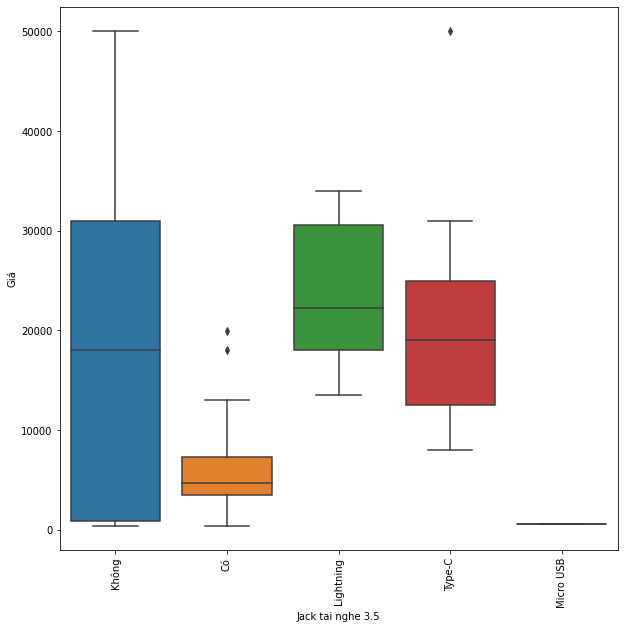

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.boxplot(x = 'Jack tai nghe 3.5',y = 'Giá', data = df_buoc3, ax = ax)
plt.xticks(rotation = 90)

Khi quan sát biểu đồ trên, chúng em nhận thấy không có sự cách biệt rõ ràng giữa việc có và không có jack tai nghe. Tuy nhiên, giữa các loại jack cắm khác nhau. Cụ thể, jack lightning có tầm giá cao nhất, sau đó đến Type-C và cuối cùng là jack tai nghe 3.5mm thông thường và Micro USB.

## 'Nguồn'

In [ ]:
var = 'Nguồn'

In [ ]:
KiemTraThuocTinh(df_buoc3, var)


- Thuộc tính Nguồn có tổng cộng 266 dòng.

- Số điểm dữ liệu null: 0 

- Số lượng dữ liệu độc nhất:  2
- Các dữ liệu độc nhất (unique):
['Cellphones' 'TGDĐ']


(array([0, 1]), <a list of 2 Text major ticklabel objects>)

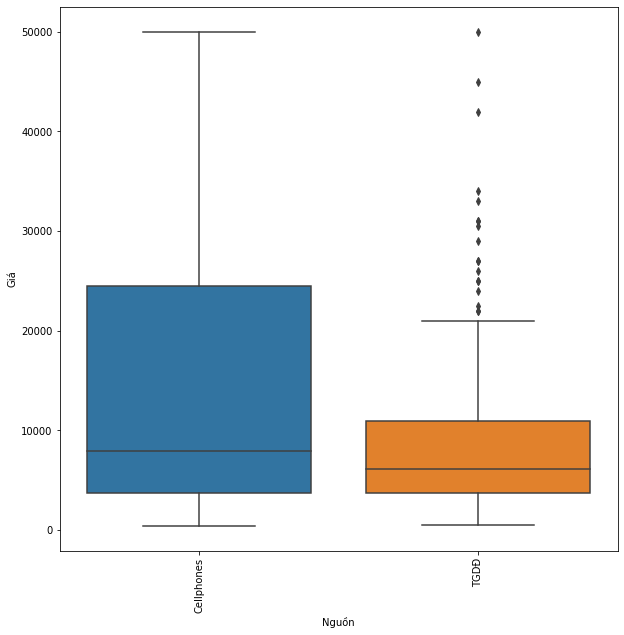

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.boxplot(x = 'Nguồn',y = 'Giá', data = df_buoc3, ax = ax)
plt.xticks(rotation = 90)

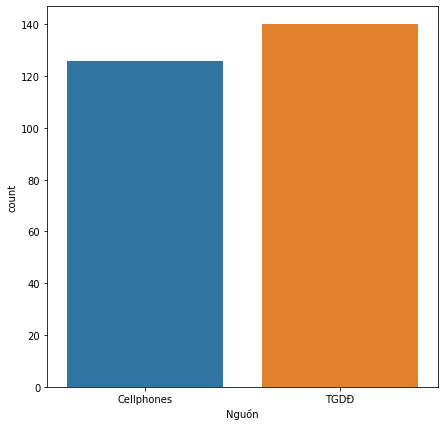

In [ ]:
plt.figure(figsize=(7, 7))
sns.countplot(x = 'Nguồn', data =df_buoc3)

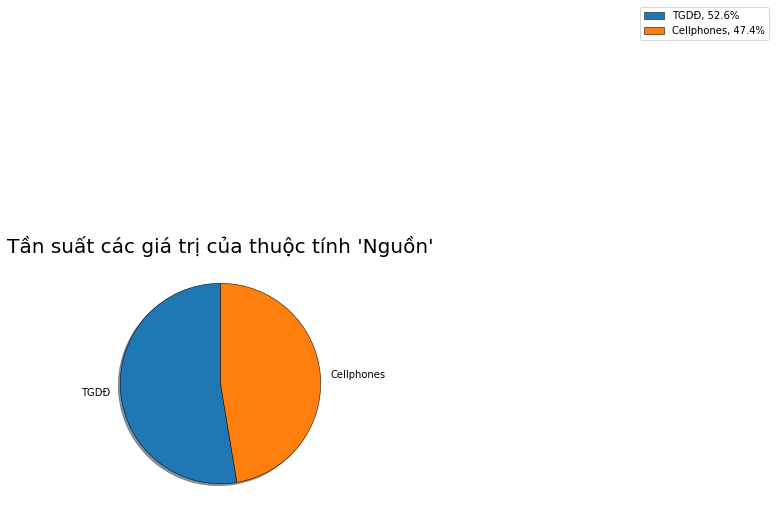

In [ ]:
Ve_Pie(df_buoc3, 'Nguồn')

Cái này tui không biết diễn giải thế nào. Có thể điện thoại Cellphones giá cao hơn TGDD chăng?

## 'Dài'

In [ ]:
var = 'Dài'

In [ ]:
KiemTraThuocTinh(df_buoc3, var)


- Thuộc tính Dài có tổng cộng 266 dòng.

- Số điểm dữ liệu null: 126 

- Số lượng dữ liệu độc nhất:  73
- Các dữ liệu độc nhất (unique):
[   nan 158.2  146.7  164.1  164.   160.2  159.9  160.3  164.5  160.5
 164.26 160.8  159.2  166.   163.6  131.5  165.1  161.5  164.3  158.3
 161.6  150.9  151.7  159.8  156.8  138.4  159.1  165.   163.9  159.68
 160.9  160.6  162.9  160.53 161.3  160.1  162.5  163.95 158.4  163.8
 162.3  158.9  161.   163.   161.8  162.1  163.86 159.3  198.   164.41
 168.4  165.2  163.96 164.2  164.9  177.7  160.97 156.   169.9  132.2
 131.4  152.5  125.3  121.   120.8  124.7   90.54 129.   102.5  136.5
 122.   115.2  130.  ]


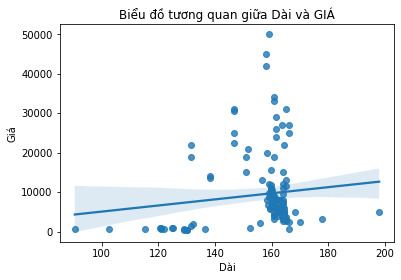

In [ ]:
sns.regplot(x=df_buoc3[var],y=df_buoc3["Giá"]).set(title='Biểu đồ tương quan giữa ' + str(var) + " và GIÁ")
plt.show()

## 'Dày'

In [ ]:
KiemTraThuocTinh(df_buoc3, 'Dày')


- Thuộc tính Dày có tổng cộng 266 dòng.

- Số điểm dữ liệu null: 129 

- Số lượng dữ liệu độc nhất:  56
- Các dữ liệu độc nhất (unique):
[  nan  6.4   7.4   8.8   9.1   7.97  8.4   7.95  8.3   8.    7.99  7.65
  6.9   8.9   7.8   8.06  8.1   7.9   9.33  7.59  7.3   7.7   9.5   7.39
  6.8   8.7   6.81  7.38  8.5   8.38  9.4   7.83  7.48  8.95  8.6   9.6
  8.41  9.    8.92  8.28  9.8   9.9   8.55  9.46 12.3  13.7  10.4  14.5
 13.8  15.   17.8  17.5  15.3  14.3  22.   13.9 ]


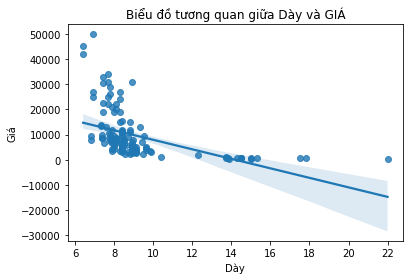

In [ ]:
sns.regplot(x=df_buoc3['Dày'],y=df_buoc3["Giá"]).set(title='Biểu đồ tương quan giữa ' + 'Dày' + " và GIÁ")
plt.show()

## 'Rộng'

In [ ]:
KiemTraThuocTinh(df_buoc3, 'Rộng')


- Thuộc tính Rộng có tổng cộng 266 dòng.

- Số điểm dữ liệu null: 129 

- Số lượng dữ liệu độc nhất:  67
- Các dữ liệu độc nhất (unique):
[   nan 128.1   71.5   76.9    7.6   73.38  75.1   73.8   76.    74.5
  72.5   78.1  128.2   72.2   74.    64.2   75.6   74.6   73.2   75.7
  71.2   76.4   72.1   67.3   73.4   73.9   77.4   76.3   74.3   74.7
  74.2   74.8   75.3   73.7   76.5   75.8   75.46  75.4   73.6   74.08
  73.77  75.5   73.1   75.9   75.53  77.2   77.3   75.2   77.07  79.1
  77.8   77.9   56.5   53.    71.    54.    50.    53.5   51.    56.
  51.5   55.    57.    49.9   61.    55.3   63.  ]


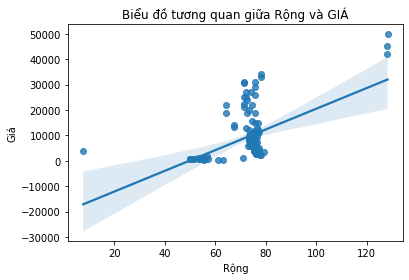

In [ ]:
sns.regplot(x=df_buoc3['Rộng'],y=df_buoc3["Giá"]).set(title='Biểu đồ tương quan giữa ' + 'Rộng' + " và GIÁ")
plt.show()

## 'Loại pin'

In [ ]:
KiemTraThuocTinh(df_buoc3, 'Loại pin')


- Thuộc tính Loại pin có tổng cộng 266 dòng.

- Số điểm dữ liệu null: 75 

- Số lượng dữ liệu độc nhất:  3
- Các dữ liệu độc nhất (unique):
[nan 'Li-Po' 'Li-Ion']


(array([0, 1]), <a list of 2 Text major ticklabel objects>)

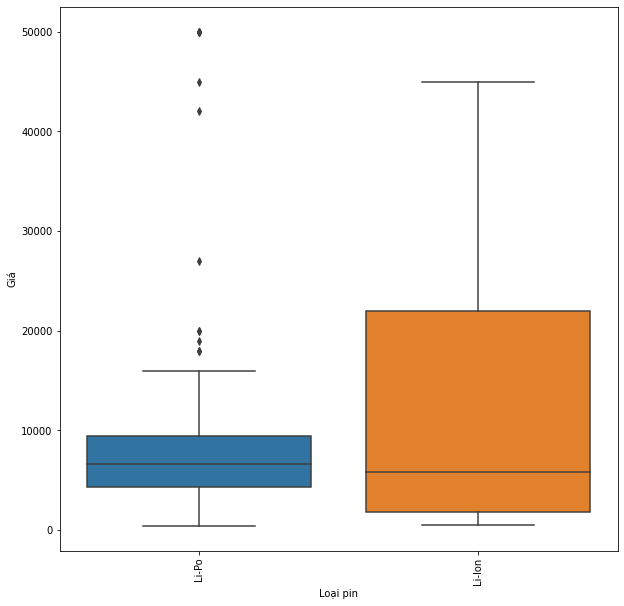

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.boxplot(x = 'Loại pin',y = 'Giá', data = df_buoc3, ax = ax)
plt.xticks(rotation = 90)


## 'Dung lượng pin'

In [ ]:
KiemTraThuocTinh(df_buoc3, 'Dung lượng pin')


- Thuộc tính Dung lượng pin có tổng cộng 266 dòng.

- Số điểm dữ liệu null: 156 

- Số lượng dữ liệu độc nhất:  30
- Các dữ liệu độc nhất (unique):
[5000. 4800. 4250. 4500. 4325. 4400. 3095.   nan 3969.  460. 2406. 3300.
 6000. 3110. 5050. 4200. 4450. 4600. 2942. 4300. 4000. 4310. 5020. 2900.
 4230. 2950. 1500. 1020.  800. 3000.]


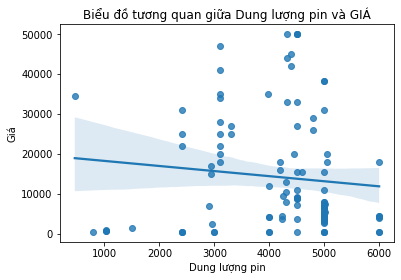

In [ ]:
sns.regplot(x=df_buoc3['Dung lượng pin'],y=df_buoc3["Giá"]).set(title='Biểu đồ tương quan giữa ' + 'Dung lượng pin' + " và GIÁ")
plt.show()

## Loại pin + Cảm biến

In [ ]:
df_buoc3['Cảm biến + loại pin'] = df_buoc3['Loại pin'] + ' + ' + df_buoc3['Cảm biến']
df_buoc3['Cảm biến + loại pin']

0                                    NaN
1      Li-Po + Mở khoá vân tay cạnh viền
2                                    NaN
3                                    NaN
4                                    NaN
                     ...                
261                                  NaN
262                                  NaN
263                                  NaN
264                                  NaN
265                                  NaN
Name: Cảm biến + loại pin, Length: 266, dtype: object

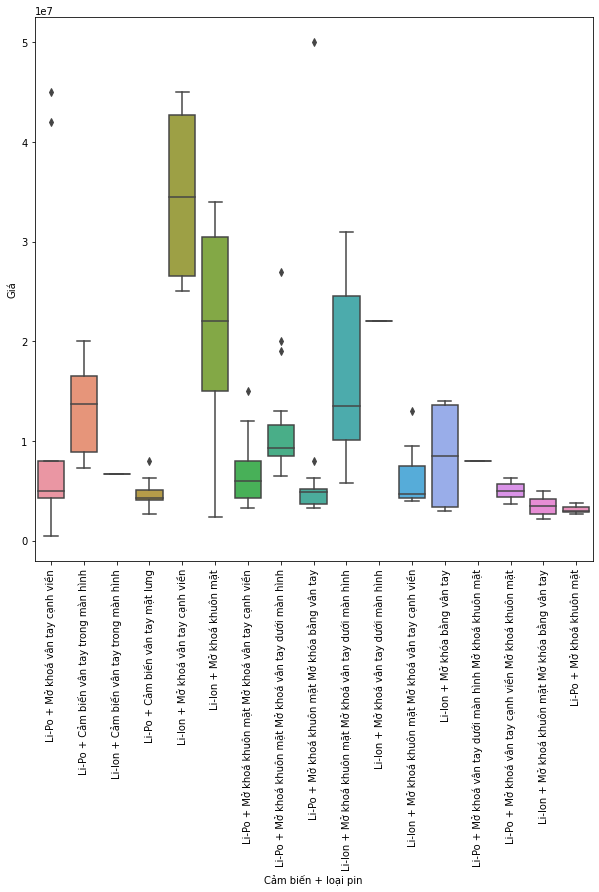

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.boxplot(x = 'Cảm biến + loại pin',y = 'Giá', data = df_buoc3)
plt.xticks(rotation = 90)
plt.show()

# Tổng hợp plot

In [ ]:
df_buoc3=pd.read_excel("/content/dienthoai_buoc4.xlsx")

In [ ]:
# Không tính cột tên & giá
text_cols = [col for col in list(df_buoc3.columns)[2:] if dict(df_buoc3.dtypes)[col] == np.dtype('O')]
numeric_cols = [col for col in list(df_buoc3.columns)[2:] if dict(df_buoc3.dtypes)[col] == np.dtype('float64')]
print(len(text_cols))
print(text_cols)
print(len(numeric_cols))
print(numeric_cols)

27
['Công nghệ màn hình', 'Camera sau', 'Camera trước', 'CPU', 'Dung lượng RAM', 'Bộ nhớ trong', 'Thẻ SIM', 'Hệ điều hành', 'Độ phân giải màn hình', 'Loại CPU', 'Quay video', 'Tính năng camera', 'GPU', 'Khe cắm thẻ nhớ', 'Công nghệ sạc', 'Cổng sạc', 'Wi-Fi', 'Bluetooth', 'GPS', 'Chất liệu mặt lưng', 'Chất liệu khung viền', 'Chỉ số kháng nước, bụi', 'Cảm biến', 'Tính năng đặc biệt', 'Jack tai nghe 3.5', 'Nguồn', 'Loại pin']
6
['Kích thước màn hình', 'Trọng lượng', 'Dài', 'Dày', 'Rộng', 'Dung lượng pin']


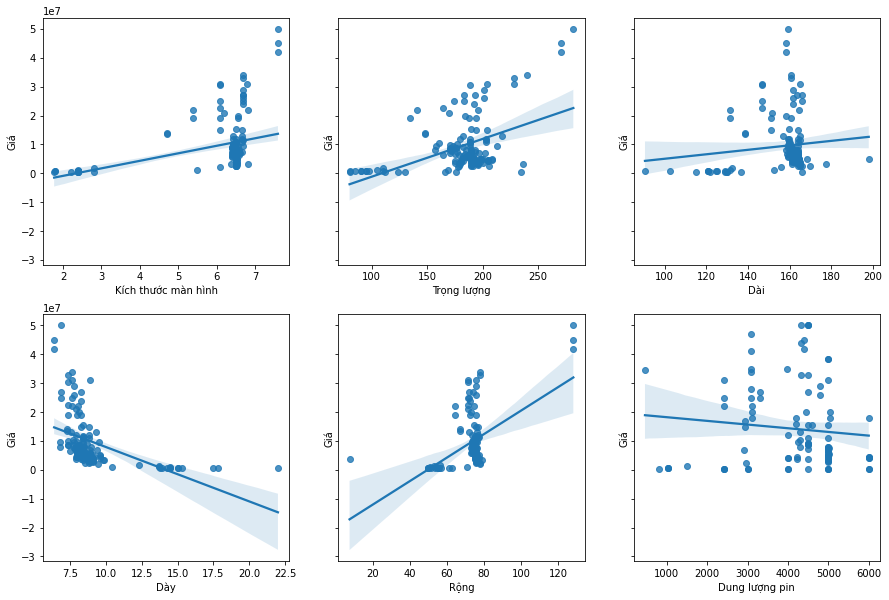

In [ ]:
figure, axis = plt.subplots(2, 3, figsize=(15, 10), sharey=True) # 2 row & 3 columns
index = 0
for i in range(2):
  for j in range(3):
    sns.set_palette('pastel')
    sns.regplot(x=df_buoc3[numeric_cols[index]],y=df_buoc3["Giá"], ax=axis[i, j])
    axis[i, j].set_xlabel(numeric_cols[index])
    index += 1

plt.show()

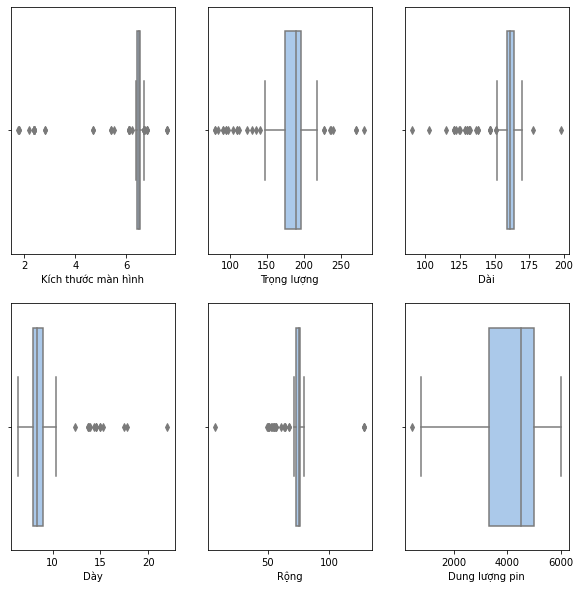

In [ ]:
figure, axis = plt.subplots(2, 3, figsize=(10, 10), sharey=True) # 2 row & 3 columns
index = 0
for i in range(2):
  for j in range(3):
    sns.set_palette('pastel')
    sns.boxplot(x=df_buoc3[numeric_cols[index]], ax=axis[i, j])
    axis[i, j].set_xlabel(numeric_cols[index])
    index += 1

plt.show()

In [ ]:
# tiếp tục vẽ biểu đồ tổng hợp cho các thuộc tính phân loại:
print(text_cols)

['Công nghệ màn hình', 'Camera sau', 'Camera trước', 'CPU', 'Dung lượng RAM', 'Bộ nhớ trong', 'Thẻ SIM', 'Hệ điều hành', 'Độ phân giải màn hình', 'Loại CPU', 'Quay video', 'Tính năng camera', 'GPU', 'Khe cắm thẻ nhớ', 'Công nghệ sạc', 'Cổng sạc', 'Wi-Fi', 'Bluetooth', 'GPS', 'Chất liệu mặt lưng', 'Chất liệu khung viền', 'Chỉ số kháng nước, bụi', 'Cảm biến', 'Tính năng đặc biệt', 'Jack tai nghe 3.5', 'Nguồn', 'Loại pin']


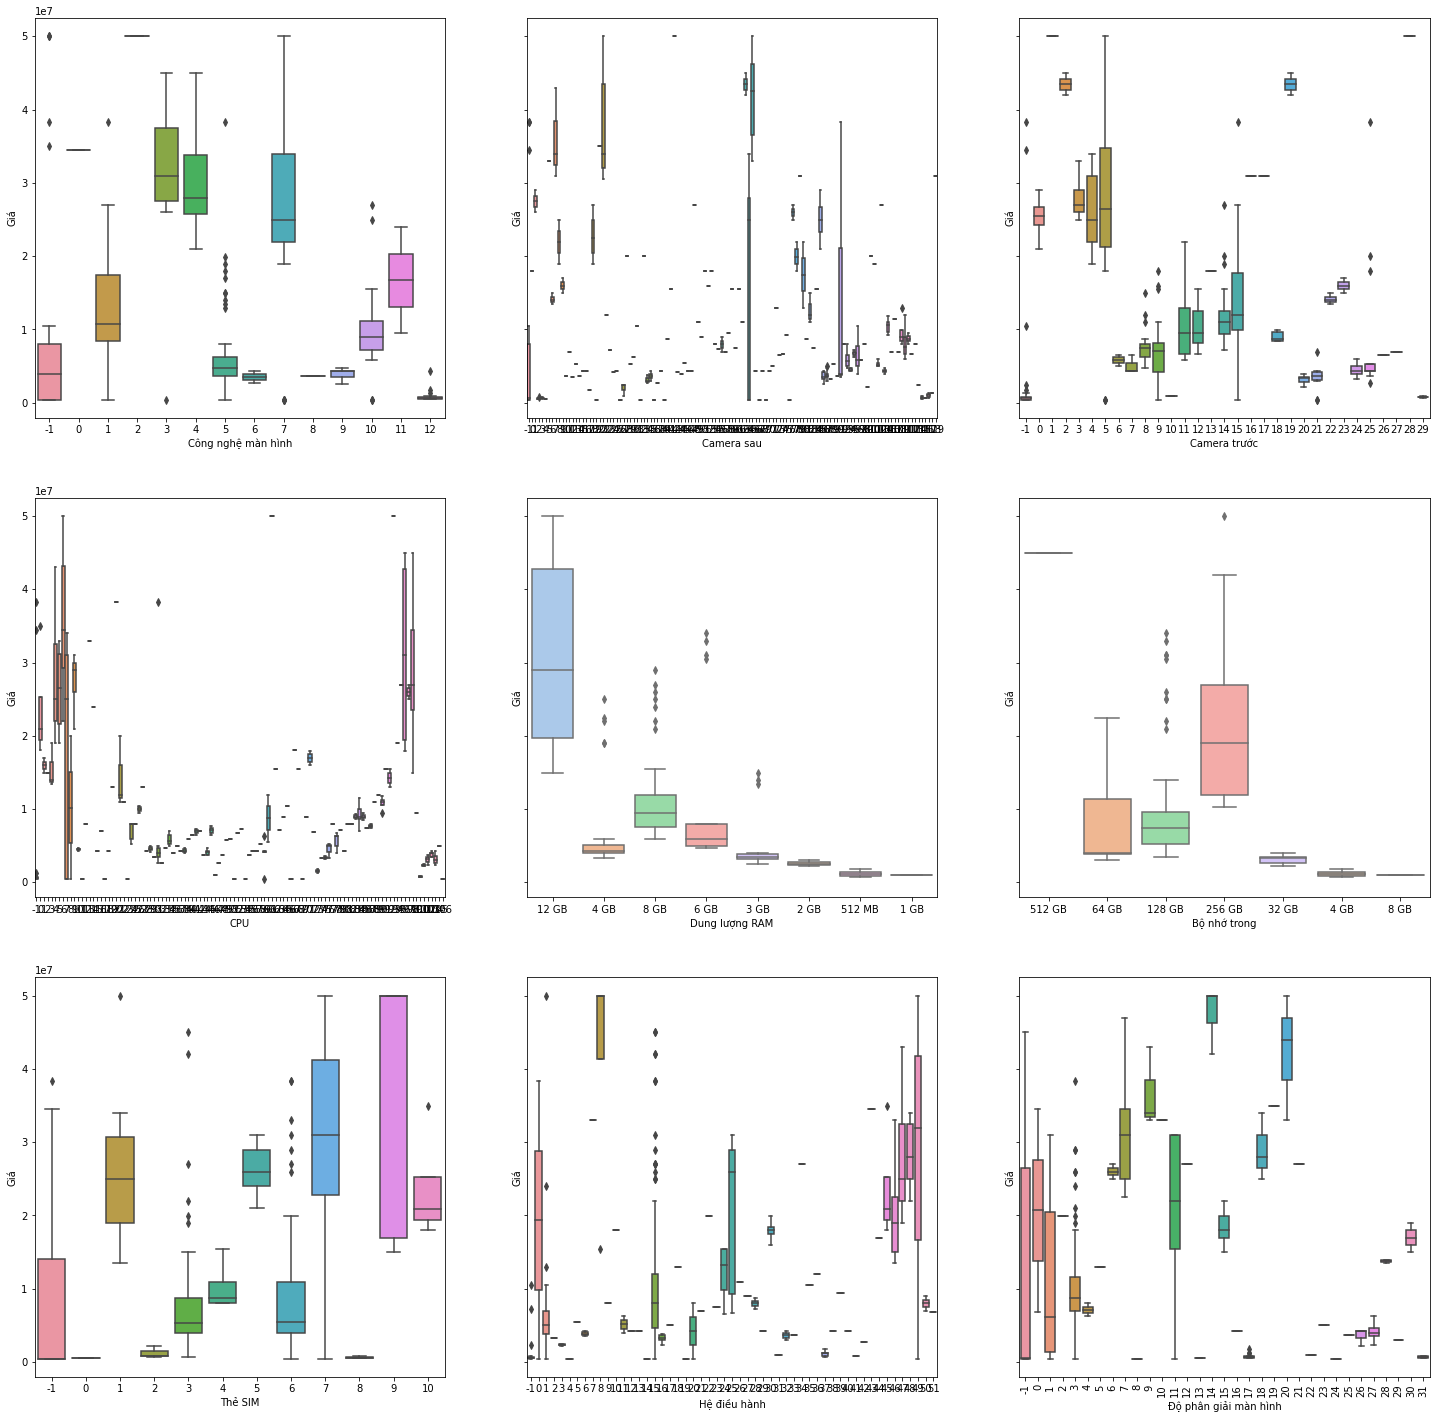

In [ ]:
# Lần 1
figure, axis = plt.subplots(3, 3, figsize=(25, 25), sharey=True) # 3 row & 3 columns
index = 0
for i in range(3):
  for j in range(3):
    sns.set_palette('pastel')
    if len(df_buoc3[text_cols[:9][index]].unique()) >=10:
      df_encode, encoder, dict_data =encode(df_buoc3[[text_cols[:9][index]]])
      sns.boxplot(x = df_encode.iloc[:,0],y = df_buoc3["Giá"], ax = axis[i, j])
      # print("Ý nghĩa của các giá trị:", dict_data)
    else:
      sns.boxplot(x = text_cols[:9][index],y = 'Giá', data = df_buoc3, ax = axis[i, j])
    axis[i, j].set_xlabel(text_cols[:9][index])
    plt.xticks(rotation = 90)
    index += 1

plt.show()

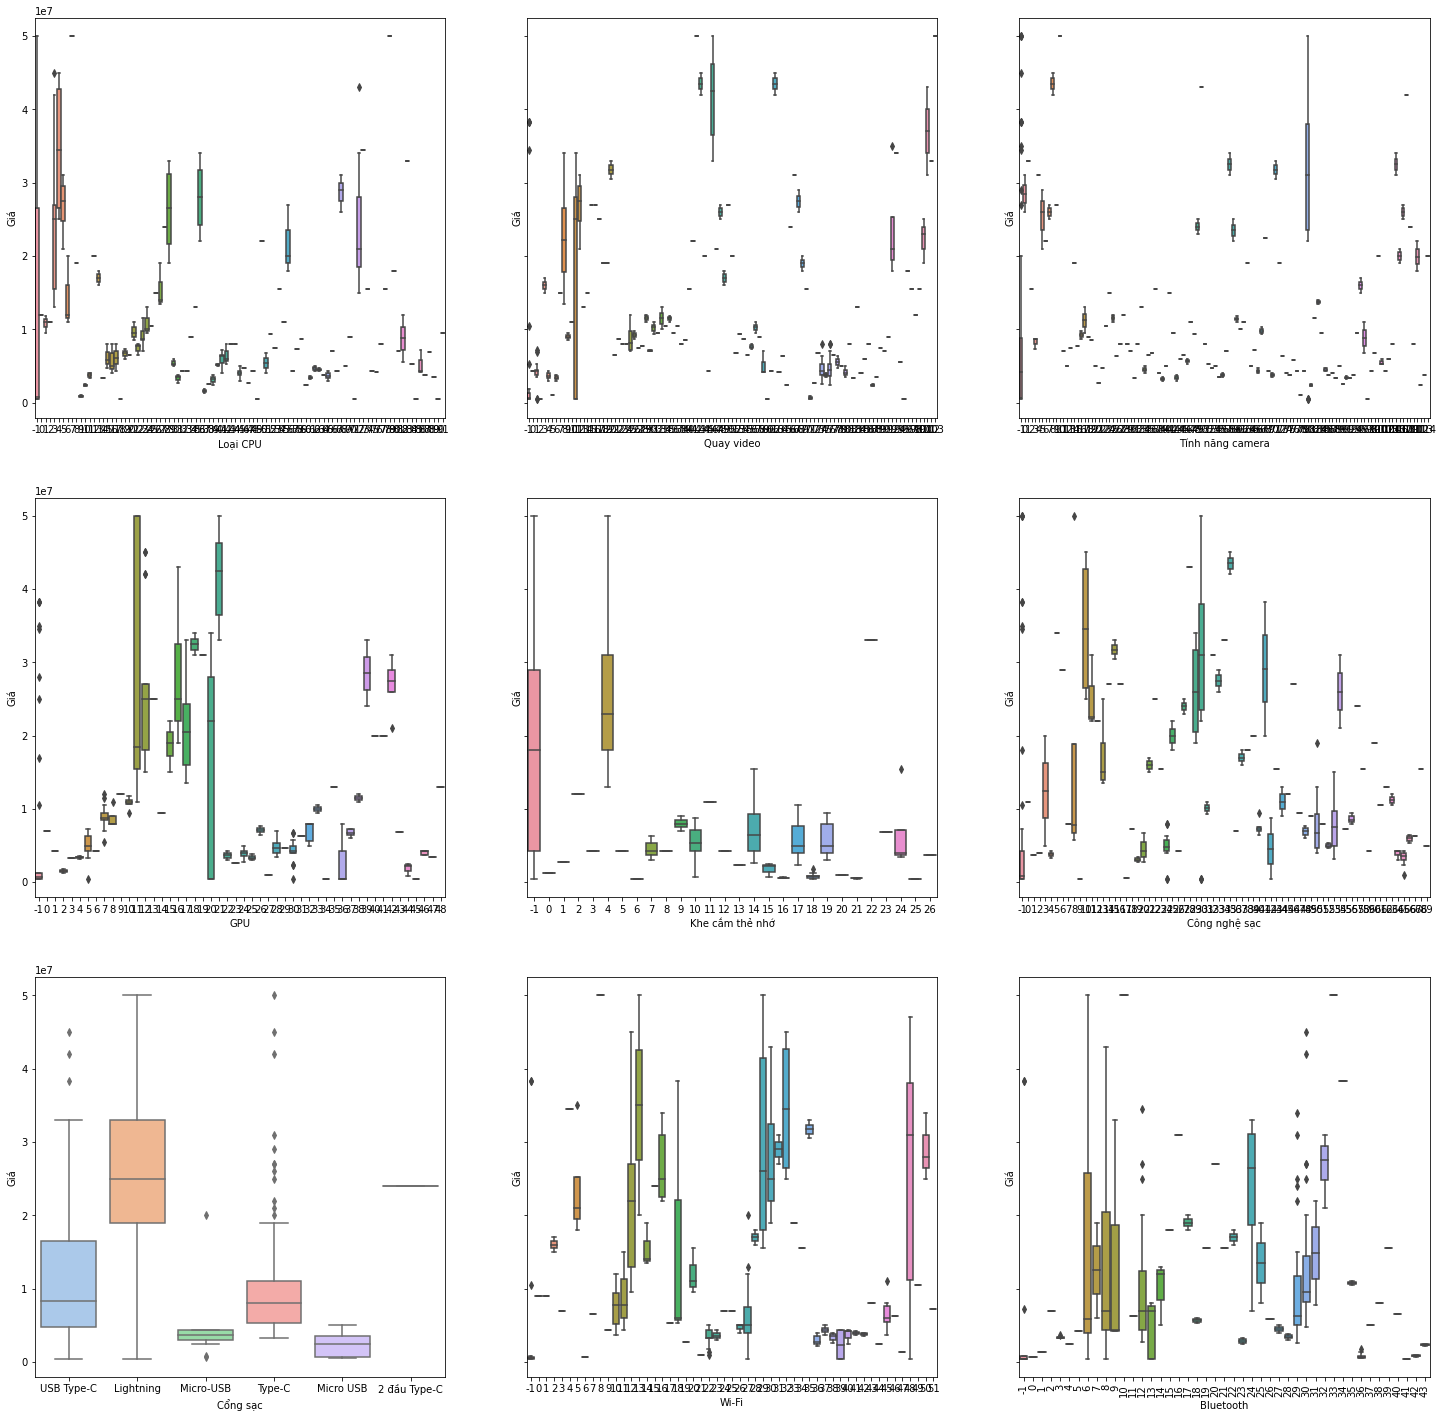

In [ ]:
# Lần 2
figure, axis = plt.subplots(3, 3, figsize=(25, 25), sharey=True) # 3 row & 3 columns
index = 0
for i in range(3):
  for j in range(3):
    sns.set_palette('pastel')
    if len(df_buoc3[text_cols[9:18][index]].unique()) >=10:
      df_encode, encoder, dict_data =encode(df_buoc3[[text_cols[9:18][index]]])
      sns.boxplot(x = df_encode.iloc[:,0],y = df_buoc3["Giá"], ax = axis[i, j])
      # print("Ý nghĩa của các giá trị:", dict_data)
    else:
      sns.boxplot(x = text_cols[9:18][index],y = 'Giá', data = df_buoc3, ax = axis[i, j])
    axis[i, j].set_xlabel(text_cols[9:18][index])
    plt.xticks(rotation = 90)
    index += 1

plt.show()

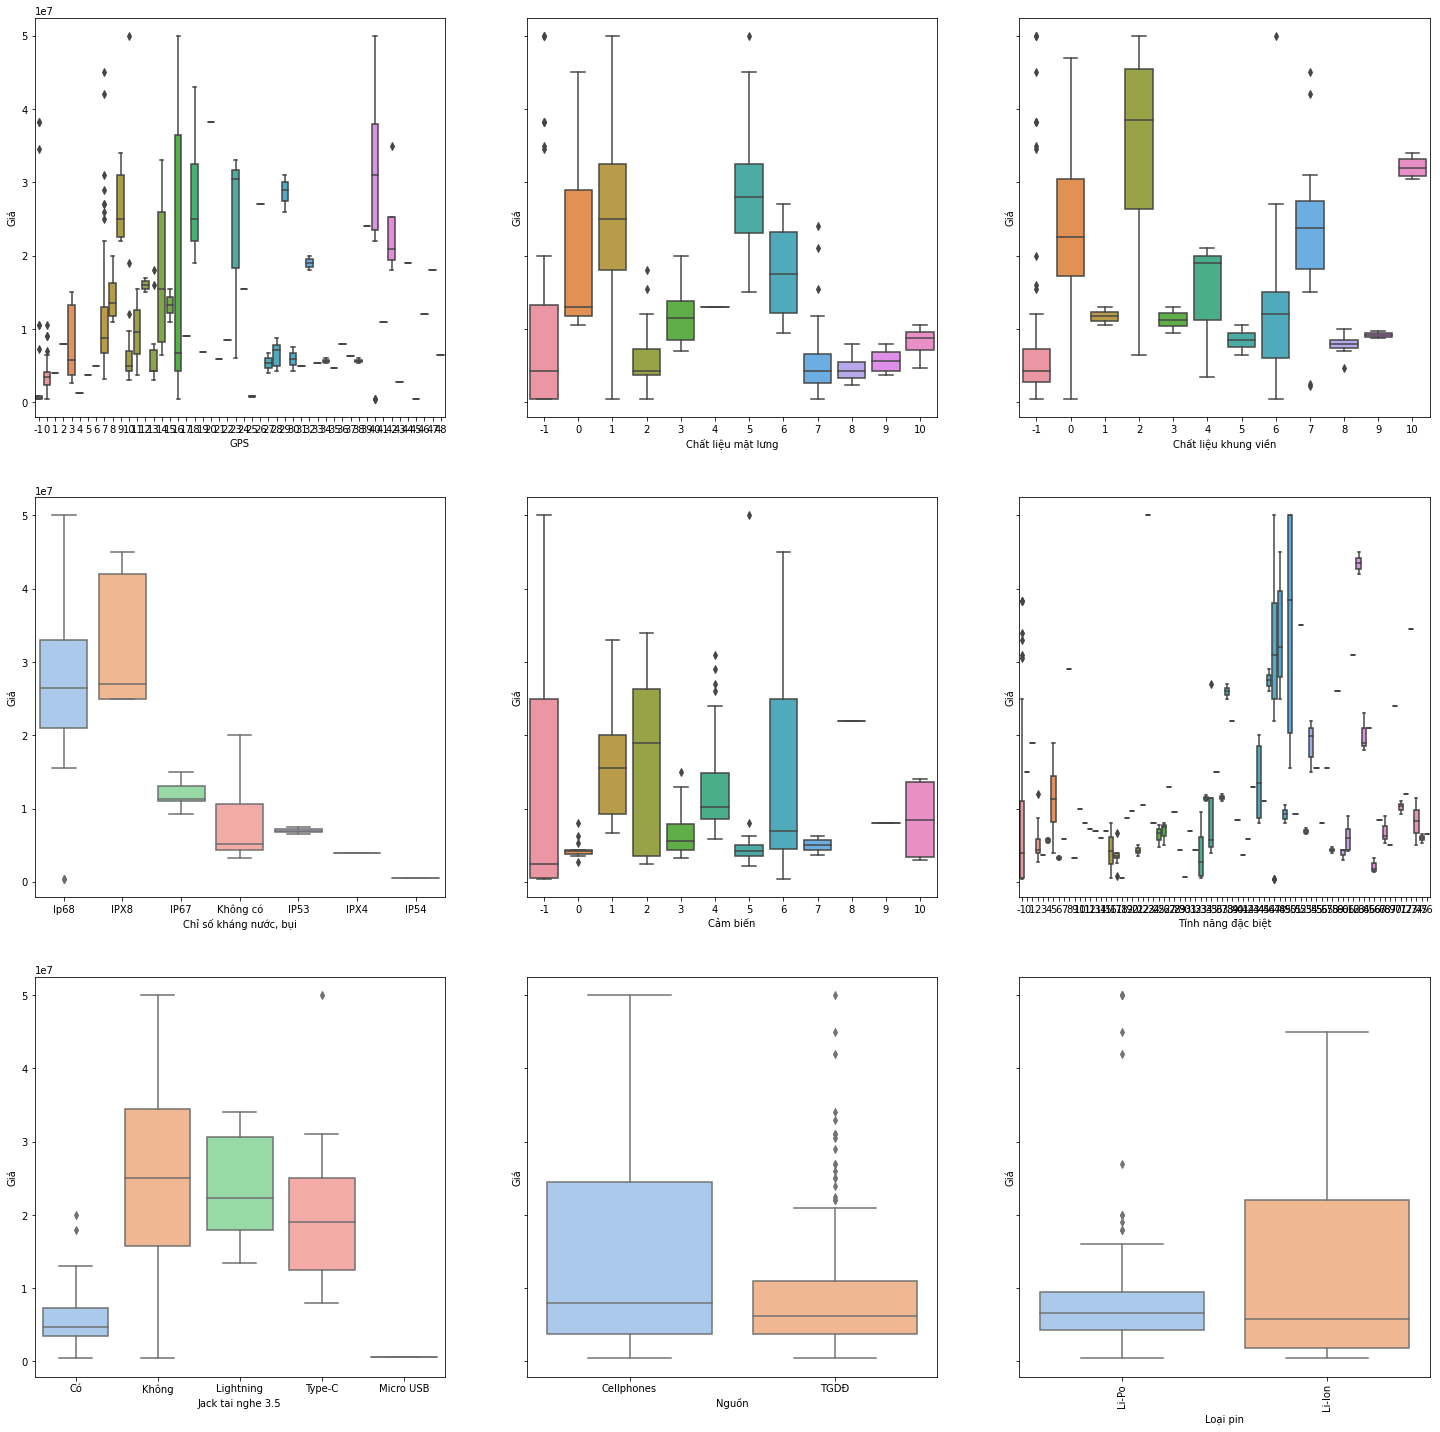

In [ ]:
# Lần 3
figure, axis = plt.subplots(3, 3, figsize=(25, 25), sharey=True) # 3 row & 3 columns
index = 0
for i in range(3):
  for j in range(3):
    sns.set_palette('pastel')
    if len(df_buoc3[text_cols[18:][index]].unique()) >10:
      df_encode, encoder, dict_data =encode(df_buoc3[[text_cols[18:][index]]])
      sns.boxplot(x = df_encode.iloc[:,0],y = df_buoc3["Giá"], ax = axis[i, j])
      plt.xticks(rotation = 90)
      # print("Ý nghĩa của các giá trị:", dict_data)
    else:
      sns.boxplot(x = text_cols[18:][index],y = 'Giá', data = df_buoc3, ax = axis[i, j])
      plt.xticks(rotation = 90)
    axis[i, j].set_xlabel(text_cols[18:][index])
    plt.xticks(rotation = 90)
    index += 1

plt.show()

#statistic test

In [ ]:
df_fill_KNN=pd.read_excel("/content/dienthoai_buoc5.xlsx")
df_fill_value=pd.read_excel("/content/dienthoai_buoc4.xlsx")

In [ ]:
for i in df_fill_value:
  df_fill_value[i].fillna(-1, inplace = True)

In [ ]:
print(df_fill_value.isna().sum().sum())
print(df_fill_KNN.isna().sum().sum())

0
0


##Chi-square test

Giả thuyết: 

1.   H0: Không có mối quan hệ giữa 2 thuộc tính
2.   H1: Có mối quan hệ giữa 2 thuộc tính





In [ ]:
class ChiSquare:
    def __init__(self, dataframe):
        self.df = dataframe
        self.p = None #P-Value
        self.chi2 = None #Chi Test Statistic
        self.dof = None
        
        self.dfObserved = None
        self.dfExpected = None

    def _print_chisquare_result(self, colX, alpha):
        result = ""
        if self.p<alpha:
            result="{0} is IMPORTANT for Prediction".format(colX)
        else:
            result="{0} is NOT an important predictor. (Discard {0} from model)".format(colX)
        print("Chi square test cột {}".format(colX))
        print("P-value:",self.p)
        print("Degree of Freefom:",self.dof)
        print(self.chi2)
        print(result)
        print("")
        print("----------~O~----------------------~O~-----------------------~O~------------------")
        print("")

    def TestIndependence(self,colX,colY, alpha=0.05): #p-value <0.05 thì phủ định H0
        X = self.df[colX].astype(str)
        Y = self.df[colY].astype(str)
        
        self.dfObserved = pd.crosstab(Y,X) 
        chi2, p, dof, expected = stats.chi2_contingency(self.dfObserved.values)
        self.p = p
        self.chi2 = chi2
        self.dof = dof 
        
        self.dfExpected = pd.DataFrame(expected, columns=self.dfObserved.columns, index = self.dfObserved.index)
        
        self._print_chisquare_result(colX,alpha)

In [ ]:
df_categorical_KNN=df_fill_KNN.copy()
df_categorical_value=df_fill_value.copy()

In [ ]:
for i in df_categorical_value.columns:
  if df_categorical_value[i].dtype != object and i!="Giá":
    df_categorical_value.drop(axis=1,columns=[i],inplace=True)

for i in df_categorical_KNN.columns:
  if df_categorical_KNN[i].dtype != object and i!="Giá":
    df_categorical_KNN.drop(axis=1,columns=[i],inplace=True)

In [ ]:
df_categorical_value.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 266 entries, 0 to 265
Data columns (total 29 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Tên                     266 non-null    object
 1   Giá                     266 non-null    int64 
 2   Công nghệ màn hình      266 non-null    object
 3   Camera sau              266 non-null    object
 4   Camera trước            266 non-null    object
 5   CPU                     266 non-null    object
 6   Dung lượng RAM          266 non-null    object
 7   Bộ nhớ trong            266 non-null    object
 8   Thẻ SIM                 266 non-null    object
 9   Hệ điều hành            266 non-null    object
 10  Độ phân giải màn hình   266 non-null    object
 11  Loại CPU                266 non-null    object
 12  Quay video              266 non-null    object
 13  Tính năng camera        266 non-null    object
 14  GPU                     266 non-null    object
 15  Khe cắ

In [ ]:
df_categorical_KNN.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 266 entries, 0 to 265
Data columns (total 29 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Tên                     266 non-null    object
 1   Giá                     266 non-null    int64 
 2   Công nghệ màn hình      266 non-null    object
 3   Camera sau              266 non-null    object
 4   Camera trước            266 non-null    object
 5   CPU                     266 non-null    object
 6   Dung lượng RAM          266 non-null    object
 7   Bộ nhớ trong            266 non-null    object
 8   Thẻ SIM                 266 non-null    object
 9   Hệ điều hành            266 non-null    object
 10  Độ phân giải màn hình   266 non-null    object
 11  Loại CPU                266 non-null    object
 12  Quay video              266 non-null    object
 13  Tính năng camera        266 non-null    object
 14  GPU                     266 non-null    object
 15  Khe cắ

###KNN

In [ ]:
cT = ChiSquare(df_categorical_KNN)
#Feature Selection
testColumns = df_categorical_KNN.columns
for var in testColumns:
    cT.TestIndependence(colX=var,colY="Giá")



Chi square test cột Tên
P-value: 1.1334586252137037e-54
Degree of Freefom: 22473
25926.79460784314
Tên is IMPORTANT for Prediction

----------~O~----------------------~O~-----------------------~O~------------------

Chi square test cột Giá
P-value: 0.0
Degree of Freefom: 9801
26334.000000000004
Giá is IMPORTANT for Prediction

----------~O~----------------------~O~-----------------------~O~------------------

Chi square test cột Công nghệ màn hình
P-value: 9.251676663974594e-29
Degree of Freefom: 1188
1811.0524225140211
Công nghệ màn hình is IMPORTANT for Prediction

----------~O~----------------------~O~-----------------------~O~------------------

Chi square test cột Camera sau
P-value: 0.573200347770168
Degree of Freefom: 11781
11752.032081063908
Camera sau is NOT an important predictor. (Discard Camera sau from model)

----------~O~----------------------~O~-----------------------~O~------------------

Chi square test cột Camera trước
P-value: 1.2592074678440812e-17
Degree of Freefo

###-1

In [ ]:
cT = ChiSquare(df_categorical_value)
#Feature Selection
testColumns = df_categorical_value.columns
for var in testColumns:
    cT.TestIndependence(colX=var,colY="Giá")



Chi square test cột Tên
P-value: 1.1334586252137037e-54
Degree of Freefom: 22473
25926.79460784314
Tên is IMPORTANT for Prediction

----------~O~----------------------~O~-----------------------~O~------------------

Chi square test cột Giá
P-value: 0.0
Degree of Freefom: 9801
26334.000000000004
Giá is IMPORTANT for Prediction

----------~O~----------------------~O~-----------------------~O~------------------

Chi square test cột Công nghệ màn hình
P-value: 3.295037527655303e-25
Degree of Freefom: 1287
1882.1526115456966
Công nghệ màn hình is IMPORTANT for Prediction

----------~O~----------------------~O~-----------------------~O~------------------

Chi square test cột Camera sau
P-value: 0.3088855672960282
Degree of Freefom: 11880
11956.415976955599
Camera sau is NOT an important predictor. (Discard Camera sau from model)

----------~O~----------------------~O~-----------------------~O~------------------

Chi square test cột Camera trước
P-value: 7.8037113111201885e-22
Degree of Freef

## Pearson Correlation

In [ ]:
numeric_col = [col for col in df_fill_KNN.columns if df_fill_KNN[col].dtype in ['float', 'int']][1:]
numeric_col

['Kích thước màn hình', 'Trọng lượng', 'Dài', 'Dày', 'Rộng', 'Dung lượng pin']

###KNN

In [ ]:
from scipy.stats.stats import pearsonr
p_corr = [[col, pearsonr(df_fill_KNN.loc[:, col], df_fill_KNN['Giá'])[0], 
          pearsonr(df_fill_KNN.loc[:, col], df_fill_KNN['Giá'])[1]] for col in numeric_col]
pd.DataFrame(p_corr, columns = ['Thuộc tính', 'PearsonCorrelation', 'P-value'])

,Thuộc tính,PearsonCorrelation,P-value
0,Kích thước màn hình,0.431873,1.639419e-13
1,Trọng lượng,0.229545,1.589319e-04
2,Dài,0.091828,1.352333e-01
3,Dày,-0.365806,7.623705e-10
4,Rộng,0.399699,1.265048e-11
5,Dung lượng pin,-0.059165,3.364300e-01


Kết luận:
- Thuộc tính _'Kích thước màn hình', 'Trọng lượng', 'Rộng'_ có mức độ tương quan thuận vừa với biến đầu ra. Giá trị P-value < 0.001 thể hiện mức độ chắc chắn mạnh về tương quan.
- Thuộc tính _'Dày'_ có mức độ tương quan nghịch vừa đối với thuộc tính đầu ra. 
- Còn lại, _Dài, Dung lượng pin_ ít tương quan với biến đầu ra "Giá".

###-1

In [ ]:
from scipy.stats.stats import pearsonr
p_corr = [[col, pearsonr(df_fill_value.loc[:, col], df_fill_value['Giá'])[0], 
          pearsonr(df_fill_value.loc[:, col], df_fill_value['Giá'])[1]] for col in numeric_col]
pd.DataFrame(p_corr, columns = ['Thuộc tính', 'PearsonCorrelation', 'P-value'])

,Thuộc tính,PearsonCorrelation,P-value
0,Kích thước màn hình,-0.130768,0.033017
1,Trọng lượng,-0.122923,0.045179
2,Dài,-0.188231,0.002049
3,Dày,-0.254524,0.000027
4,Rộng,-0.111386,0.069717
5,Dung lượng pin,0.127156,0.038218


Kết luận:
- Cột 'Kích thước màn hình', 'Trọng lượng', 'Dày', 'Dài' tương quan nghịch yếu đối với biến đầu ra. Tuy nhiên chỉ có thuộc tính _Dày_ với p-value rất nhỏ làm chúng ta tự tin với phán đoán này.
- Cột 'Dung lượng pin' tương quan thuận yếu đối với biến đầu ra.
- Cột _Rộng_ không tương quan, bởi giá trị p-value quá cao làm chúng ta không chắc chắn được điều gì.

#Chọn thuộc tính

##KNN

In [ ]:
df_select_KNN=df_fill_KNN.drop(axis=1,columns=["Camera sau","CPU","Loại CPU","Quay video","Tính năng camera","Khe cắm thẻ nhớ","Công nghệ sạc", 'Dài', 'Dung lượng pin',"Chất liệu mặt lưng","Nguồn"])

In [ ]:
df_select_KNN.to_excel("dienthoai_select_KNN.xlsx",index=False)

##-1

In [ ]:
df_select_value=df_fill_value.drop(axis=1,columns=['Rộng', "Camera sau","CPU","Loại CPU","Tính năng camera","Công nghệ sạc","Chất liệu mặt lưng","Nguồn"])

In [ ]:
df_select_value.to_excel("dienthoai_select_value.xlsx",index=False)